In [1]:

import pandas as pd
import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split
import GPUtil
import itertools
import pickle
import torch
from pathlib import Path
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
from sklearn.preprocessing import Normalizer
import joblib
import ili  # Import ili for the SBI functionality
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

from sbi.utils.user_input_checks import process_prior

sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params_1P import plot_uvlf, plot_colour
from setup_params_SB import *
from priors_SB import initialise_priors_SB28
from variables_config_28 import uvlf_limits, n_bins_lf, colour_limits, n_bins_colour
# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
model = "IllustrisTNG"
spec_type = "attenuated"
sps = "BC03"
snap = ["044"]
bands = "all" # or just GALEX?

colours = False  
luminosity_functions = True
name = f"{model}_{bands}_{sps}_{spec_type}_{n_bins_lf}_{n_bins_colour}"

cam = camels(model=model, sim_set='SB28')

if colours and not luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/colours_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/colours_only/"
    
elif luminosity_functions and not colours:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only/"

elif colours and luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/colours_lfs/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/colours_lfs/"

else:
    raise ValueError("At least one of colours or luminosity_functions must be True")

print("Saving model in ", model_out_dir)
print("Saving plots in ", plots_out_dir)



Saving model in  /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only/
Saving plots in  /disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only/


In [2]:
print(uvlf_limits)

(-25, -14)


In [3]:
# Quick check of available data
with h5py.File("/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/photometry/alice_galex.h5", "r") as hf:
    print("Available simulations:", list(hf.keys()))
    sim_key = list(hf.keys())[0]  # First simulation
    print("\nStructure for first simulation:")
    print(list(hf[f"{sim_key}/snap_044/BC03/photometry/luminosity/attenuated"].keys()))

Available simulations: ['SB28_0', 'SB28_1', 'SB28_10', 'SB28_100', 'SB28_1000', 'SB28_1001', 'SB28_1002', 'SB28_1003', 'SB28_1004', 'SB28_1005', 'SB28_1006', 'SB28_1007', 'SB28_1008', 'SB28_1009', 'SB28_101', 'SB28_1010', 'SB28_1011', 'SB28_1012', 'SB28_1013', 'SB28_1014', 'SB28_1015', 'SB28_1016', 'SB28_1017', 'SB28_1018', 'SB28_1019', 'SB28_102', 'SB28_1020', 'SB28_1021', 'SB28_1022', 'SB28_1023', 'SB28_1024', 'SB28_1025', 'SB28_1026', 'SB28_1027', 'SB28_1028', 'SB28_1029', 'SB28_103', 'SB28_1030', 'SB28_1031', 'SB28_1032', 'SB28_1033', 'SB28_1034', 'SB28_1035', 'SB28_1036', 'SB28_1037', 'SB28_1038', 'SB28_1039', 'SB28_104', 'SB28_1040', 'SB28_1041', 'SB28_1042', 'SB28_1043', 'SB28_1044', 'SB28_1045', 'SB28_1046', 'SB28_1047', 'SB28_1048', 'SB28_1049', 'SB28_105', 'SB28_1050', 'SB28_1051', 'SB28_1052', 'SB28_1053', 'SB28_1054', 'SB28_1055', 'SB28_1056', 'SB28_1057', 'SB28_1058', 'SB28_1059', 'SB28_106', 'SB28_1060', 'SB28_1061', 'SB28_1062', 'SB28_1063', 'SB28_1064', 'SB28_1065', 'SB

          #Name    Omega0    sigma8  WindEnergyIn1e51erg  RadioFeedbackFactor  \
0        SB28_0  0.352541  0.694742              3.85743             1.519210   
1        SB28_1  0.172430  0.830154              1.03554             0.797734   
2        SB28_2  0.234683  0.705844              9.61416             3.380650   
3        SB28_3  0.440288  0.969259              2.14363             0.488165   
4        SB28_4  0.457152  0.786733              1.38466             0.325727   
...         ...       ...       ...                  ...                  ...   
2043  SB28_2043  0.457334  0.970226              8.89733             0.607197   
2044  SB28_2044  0.440496  0.786137              5.34131             0.880840   
2045  SB28_2045  0.234475  0.938760              1.49723             1.873430   
2046  SB28_2046  0.172613  0.612888             13.31250             0.363806   
2047  SB28_2047  0.352358  0.862216              3.09935             3.331570   

      VariableWindVelFactor

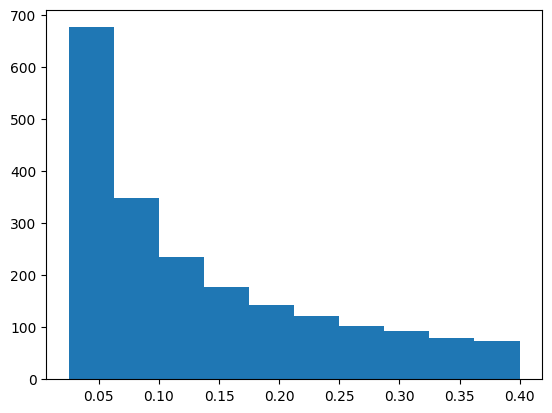

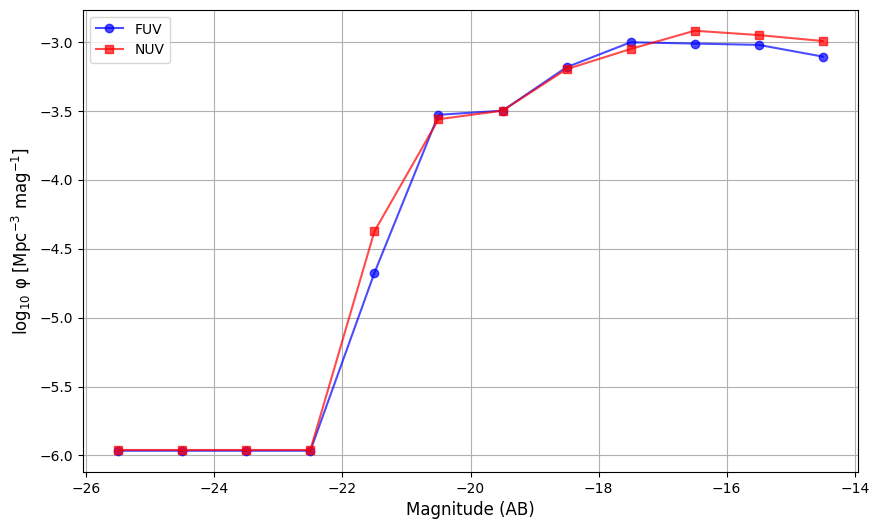

processing Omega0:
processing Omega0 is linear with min 0.1 and max 0.5:
processing sigma8:
processing sigma8 is linear with min 0.6 and max 1.0:
processing WindEnergyIn1e51erg:
processing WindEnergyIn1e51erg is logarithmic with min 0.9 and max 14.4:
processing RadioFeedbackFactor:
processing RadioFeedbackFactor is logarithmic with min 0.25 and max 4.0:
processing VariableWindVelFactor:
processing VariableWindVelFactor is logarithmic with min 3.7 and max 14.8:
processing RadioFeedbackReiorientationFactor:
processing RadioFeedbackReiorientationFactor is logarithmic with min 10.0 and max 40.0:
processing OmegaBaryon:
processing OmegaBaryon is linear with min 0.029 and max 0.069:
processing HubbleParam:
processing HubbleParam is linear with min 0.4711 and max 0.8711:
processing n_s:
processing n_s is linear with min 0.7624 and max 1.1624:
processing MaxSfrTimescale:
processing MaxSfrTimescale is logarithmic with min 1.135 and max 4.54:
processing FactorForSofterEQS:
processing FactorForSo

/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 28 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:209: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  warnings.warn(
/tmp/ipykernel_1700251/578055196.py:73: UserWarning: To copy construct from a

tensor([[-5.9655, -5.9655, -5.9655,  ..., -2.9198, -2.9514, -2.9944],
        [-5.9743, -5.9743, -5.9743,  ..., -2.5617, -2.4853, -2.3535],
        [-5.9983, -5.9983, -4.6757,  ..., -2.6586, -2.7463, -2.7463],
        ...,
        [-5.9836, -5.9836, -5.9836,  ..., -2.6188, -2.6934, -2.6303],
        [-5.9781, -5.9781, -5.9781,  ..., -3.5295, -3.5617, -3.5617],
        [-5.9661, -5.9661, -5.9661,  ..., -2.3514, -2.3834, -2.4853]],
       device='cuda:0')
theta: tensor([[3.5254e-01, 6.9474e-01, 3.8574e+00,  ..., 2.2539e-01, 2.6936e-04,
         5.1465e-01],
        [1.7243e-01, 8.3015e-01, 1.0355e+00,  ..., 8.6231e-02, 2.2802e-02,
         2.6208e+00],
        [2.3468e-01, 7.0584e-01, 9.6142e+00,  ..., 6.4810e-01, 1.4576e-03,
         3.3896e+00],
        ...,
        [2.3448e-01, 9.3876e-01, 1.4972e+00,  ..., 6.8262e-01, 6.2632e-03,
         3.1172e+00],
        [1.7261e-01, 6.1289e-01, 1.3312e+01,  ..., 8.3655e-02, 7.0985e-05,
         2.8879e+00],
        [3.5236e-01, 8.6222e-01, 3.09

In [4]:
# parameter info file (df_info) is used for defining priors
# the actual parameter values come from the camels class which reads CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt

#  parameters defined here: /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt which is used for theta
df_pars = pd.read_csv('/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt', delim_whitespace=True)
print(df_pars)

param_names = df_pars.columns[1:29].tolist()  # Excluding 'name' column

# prior values come from this:
df_info = pd.read_csv("/disk/xray15/aem2/data/28pams/Info_IllustrisTNG_L25n256_28params.txt")
print(df_info)

theta = df_pars.iloc[:, 1:29].to_numpy()  # excluding 'name' column and 'seed' column

print(theta)
print(theta.shape)
print("Column names:")
print(df_pars.columns.tolist())
# plot the first one (omega0) to see shape of prior:
plt.hist(theta[:, 24])

if __name__ == "__main__":
    theta, x = get_theta_x_SB(
        luminosity_functions=luminosity_functions,
        colours=colours,
        uvlf_limits=uvlf_limits,
        colour_limits=colour_limits,
        n_bins_lf=n_bins_lf,
        n_bins_colour=n_bins_colour
    )
    print(theta.shape, x.shape)
    
# if __name__ == "__main__":
#     theta, x = get_theta_x_SB(
#         luminosity_functions=luminosity_functions,
#         colours=colours  # This will now override the default
#     )
#     print(theta.shape, x.shape)
    
if colours:
    fig = plot_colour(x)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colour_check.png')
    plt.show()

if luminosity_functions:
    fig = plot_uvlf(x)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/LFs_test/uvlf_check.png')
    plt.show()


# get the priors and data
prior = initialise_priors_SB28(
    df=df_info, 
    device=device,
    astro=True,
    dust=False  # no dust for testing. set to False to only get the 28 model parameters.
    # with dust = True, prior has 32 dimensions (28 parameters + 4 dust parameters) 
)

# process the data
x_all = np.array([np.hstack(_x) for _x in x])
x_all = torch.tensor(x_all, dtype=torch.float32, device=device)

print("Theta shape:", theta.shape)
print("X shape:", x_all.shape)


# Move data to GPU as early as possible
x_all = x_all.to(device)
print('x_all:', x_all)

theta = torch.tensor(theta, dtype=torch.float32, device=device)
print('theta:', theta)

# Handle NaN values and normalize while on GPU
x_all_cpu = x_all.cpu().numpy()  # Only move to CPU when necessary for sklearn
print('x_all_cpu:', x_all_cpu)

print("Data shape before processing:", x_all_cpu.shape)
print("Number of values:",(x_all_cpu).sum())
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())


# get rid of NaN/inf values, replace with small random noise
nan_mask = np.isnan(x_all_cpu) | np.isinf(x_all_cpu)
print('nan_mask:', nan_mask)


if nan_mask.any():
    x_all_cpu[nan_mask] = np.random.rand(np.sum(nan_mask)) * 1e-10

print("Data shape before processing:", x_all_cpu.shape)
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())

print('x_all_cpu:', x_all_cpu)


# Normalize
norm = Normalizer()

# Option: Add small constant before normalizing
epsilon = 1e-10  # Small constant
x_all_shifted = x_all_cpu + epsilon
x_all_normalized = norm.fit_transform(x_all_shifted)
x_all = torch.tensor(x_all_normalized, dtype=torch.float32, device=device)

print('x_all:', x_all)

# Save normalizer
joblib.dump(norm, f'/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/{name}_scaler.save')

# Print final check
print("Any NaN in normalized data:", torch.isnan(x_all).any().item())
print("Any inf in normalized data:", torch.isinf(x_all).any().item())


# make test mask
test_mask = create_test_mask() # 10% testing
train_mask = ~test_mask # 90% for training


param_names = df_pars.columns[1:29].tolist()  # Excluding 'name' column


In [5]:

class TrainingMonitor:
    def __init__(self, out_dir, model_name, log_to_console=True, log_to_file=False):
        self.out_dir = Path(out_dir)
        self.model_name = model_name
        self.metrics = {
            'train_loss': [],
            'val_loss': [],
            'parameter_metrics': []
        }
        
        self.logger = logging.getLogger(f'training_monitor_{model_name}')
        self.logger.setLevel(logging.INFO)
        self.logger.handlers = []
        
        if log_to_console:
            ch = logging.StreamHandler()
            ch.setLevel(logging.INFO)
            formatter = logging.Formatter('%(message)s')
            ch.setFormatter(formatter)
            self.logger.addHandler(ch)
        
        if log_to_file:
            self.out_dir.mkdir(parents=True, exist_ok=True)
            log_file = self.out_dir / f'training_log_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt'
            fh = logging.FileHandler(str(log_file))
            fh.setLevel(logging.INFO)
            formatter = logging.Formatter('%(asctime)s - %(message)s')
            fh.setFormatter(formatter)
            self.logger.addHandler(fh)
            
        if log_to_console:
            self.logger.info(f'Starting training monitor for model: {model_name}')

    def update_metrics(self, summaries):
        if not summaries:
            return
            
        train_losses = summaries[0]['training_log_probs']
        val_losses = summaries[0]['validation_log_probs']
        
        self.metrics['train_loss'] = train_losses
        self.metrics['val_loss'] = val_losses
        
        current_train = train_losses[-1] if train_losses else None
        current_val = val_losses[-1] if val_losses else None
        self.logger.info(f'Current metrics - Train Loss: {current_train:.4f}, Val Loss: {current_val:.4f}')

    def calculate_parameter_metrics(self, model, x_test, theta_test, param_names):
        """Calculate per-parameter metrics"""
        import sys, os
        n_samples = 1000
        all_metrics = []
        
        with open(os.devnull, 'w') as devnull:
            old_stdout = sys.stdout
            sys.stdout = devnull
            
            try:
                for i in range(len(x_test)):
                    with torch.no_grad():
                        samples = model.sample(
                            (n_samples,), 
                            x=x_test[i].reshape(1, -1)
                        ).cpu().numpy()
                    
                    for j, param in enumerate(param_names):
                        true_val = theta_test[i, j].cpu().numpy()
                        pred_mean = samples[:, j].mean()
                        pred_std = samples[:, j].std()
                        
                        rmse = np.sqrt(np.mean((true_val - pred_mean)**2))
                        coverage = np.mean(np.abs(true_val - pred_mean) <= 2 * pred_std)
                        
                        all_metrics.append({
                            'param': param,
                            'rmse': rmse,
                            'coverage': coverage
                        })
            finally:
                sys.stdout = old_stdout
        
        self.metrics['parameter_metrics'] = all_metrics
        self.logger.info(f'Updated parameter metrics for {len(param_names)} parameters')

    def plot_training_progress(self, summaries, config_str, model, x_test, theta_test, param_names, train_args, hidden_features, num_transforms):
        """Plot comprehensive training progress"""
        fig = plt.figure(figsize=(20, 15))
        gs = plt.GridSpec(2, 2)

        # Training and Validation Loss
        ax1 = fig.add_subplot(gs[0, 0])
        train_loss = self.metrics['train_loss']
        val_loss = self.metrics['val_loss']
        epochs = range(len(train_loss))
        
        ax1.plot(epochs, train_loss, '-', label='Training', color='blue')
        ax1.plot(epochs, val_loss, '--', label='Validation', color='red')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Log probability')
        ax1.set_title('Ensemble Average Training and Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Individual Network Performance
        ax2 = fig.add_subplot(gs[0, 1])
        colors = plt.cm.tab10(np.linspace(0, 1, len(summaries)))
        
        for i, summary in enumerate(summaries):
            ax2.plot(summary['training_log_probs'], 
                    ls='-', 
                    label=f'Net {i+1} Train',
                    color=colors[i])
            ax2.plot(summary['validation_log_probs'], 
                    ls='--', 
                    label=f'Net {i+1} Val',
                    color=colors[i],
                    alpha=0.5)
        
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Log probability')
        ax2.set_title('Individual Network Performance')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)

        # Overfitting Gap
        ax3 = fig.add_subplot(gs[1, 0])
        gap = np.array(train_loss) - np.array(val_loss)
        ax3.plot(epochs, gap, '-', color='purple')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Loss difference')
        ax3.set_title('Overfitting Gap')
        ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax3.grid(True, alpha=0.3)

        # Add configuration text
        config_text = (
            f"Training Configuration:\n"
            f"Batch Size: {train_args['training_batch_size']}\n"
            f"Learning Rate: {train_args['learning_rate']}\n"
            f"Epochs: {train_args['stop_after_epochs']}\n"
            f"Hidden Features: {hidden_features}\n"
            f"Num Transforms: {num_transforms}\n"
            f"Num Networks: {len(summaries)}"
        )
        fig.text(0.02, 0.98, config_text,
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                verticalalignment='top')

        plt.tight_layout()
        save_path = os.path.join(self.out_dir, f'training_progress_{config_str}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        self.logger.info(f'Saved training progress plot to {save_path}')
        plt.show()

    def plot_coverage_analysis(self, model, x_test, theta_test, param_names, plots_out_dir, name, config_str, train_args, hidden_features, num_transforms):
        """Plot TARP and coverage analysis"""
        import numpy as np
        import matplotlib.pyplot as plt
        import os
        
        # Calculate TARP curve
        n_samples = int(4e3)
        all_coverages = []
        
        with torch.no_grad():
            for i in range(len(x_test)):
                samples = model.sample((n_samples,), x=x_test[i].reshape(1, -1)).cpu().numpy()
                true_vals = theta_test[i].cpu().numpy()
                
                # Calculate coverage for different credible intervals
                deviations = np.abs(samples - true_vals)
                sorted_devs = np.sort(deviations, axis=0)
                
                # Calculate empirical coverage for different credible levels
                credible_levels = np.linspace(0, 1, 100)
                coverages = []
                
                for level in credible_levels:
                    threshold_idx = int(level * n_samples)
                    if threshold_idx > 0:
                        thresholds = sorted_devs[threshold_idx - 1]
                        coverage = np.mean(deviations <= thresholds)
                        coverages.append(coverage)
                    else:
                        coverages.append(0)
                
                all_coverages.append(coverages)
        
        mean_coverage = np.mean(all_coverages, axis=0)
        
        # Plot TARP
        plt.figure(figsize=(10, 8))
        plt.plot(credible_levels, mean_coverage, 'b-', label='Actual coverage')
        plt.plot([0, 1], [0, 1], 'k--', label='Ideal coverage')
        plt.xlabel('Credibility Level')
        plt.ylabel('Expected Coverage')
        plt.title('TARP (Test Analysis of Running Predictions)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add configuration text
        config_text = (
            f"Training Config:\n"
            f"Batch Size: {train_args['training_batch_size']}\n"
            f"Learning Rate: {train_args['learning_rate']}\n"
            f"Epochs: {train_args['stop_after_epochs']}\n"
            f"Hidden Features: {hidden_features}\n"
            f"Num Transforms: {num_transforms}"
        )
        
        plt.figtext(0.02, 0.98, config_text,
                    fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                    verticalalignment='top')
        
        # Save plot
        save_path = os.path.join(plots_out_dir, f'metric_tarp_{name}_{config_str}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        self.logger.info(f'Saved TARP plot to {save_path}')
        plt.show()
        plt.close()


    def plot_parameter_predictions(self, model, x_test, theta_test, param_names, plots_out_dir, model_params):
        """Plot parameter-wise predictions"""
        import sys
        with open(os.devnull, 'w') as devnull:
            old_stdout = sys.stdout
            sys.stdout = devnull
            
            try:
                n_samples = 1000
                all_means = []
                all_stds = []
                
                for i in range(len(x_test)):
                    with torch.no_grad():
                        samples = model.sample(
                            (n_samples,),
                            x=x_test[i].reshape(1, -1)
                        ).cpu().numpy()
                    
                    mean = samples.mean(axis=0)
                    std = samples.std(axis=0)
                    all_means.append(mean)
                    all_stds.append(std)
            
            finally:
                sys.stdout = old_stdout
        
        all_means = np.array(all_means)
        all_stds = np.array(all_stds)
        
        fig, axes = plt.subplots(7, 4, figsize=(16, 28))
        axes = axes.flatten()
        fontsize = 10
        
        plt.rcParams['figure.constrained_layout.use'] = True
        
        for i in range(28):
            ax = axes[i]
            ax.errorbar(
                theta_test[:, i].cpu().numpy(),
                all_means[:, i],
                yerr=all_stds[:, i],
                fmt='.',
                color='k',
                ecolor='blue',
                capsize=0,
                elinewidth=0.8,
                alpha=0.3,
                markersize=5
            )
            
            lims = [
                min(ax.get_xlim()[0], ax.get_ylim()[0]),
                max(ax.get_xlim()[1], ax.get_ylim()[1])
            ]
            ax.plot(lims, lims, '--', color='black', alpha=0.5, linewidth=1)
            
            true_vals = theta_test[:, i].cpu().numpy()
            rmse = np.sqrt(np.mean((true_vals - all_means[:, i])**2))
            r2 = np.corrcoef(true_vals, all_means[:, i])[0, 1]**2
            chi2 = np.mean(((true_vals - all_means[:, i])**2) / (all_stds[:, i]**2))
            
            stats_text = (f'RMSE = {rmse:.2f}\n'
                        f'R² = {r2:.2f}\n'
                        f'χ² = {chi2:.2f}')
            ax.text(0.05, 0.95, stats_text,
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8),
                    verticalalignment='top',
                    fontsize=fontsize-1)
            
            ax.set_title(param_names[i], fontsize=fontsize, pad=5)
            ax.set_xlabel('True', fontsize=fontsize-1)
            ax.set_ylabel('Inferred', fontsize=fontsize-1)
            ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
            ax.margins(x=0.05, y=0.05)
        
        plt.subplots_adjust(
            left=0.01, right=0.7,
            bottom=0.05, top=0.7,
            wspace=0.2, hspace=0.2
        )
        
        save_path = f'{plots_out_dir}/posterior_predictions_{model_params}.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
        self.logger.info(f'Saved parameter predictions plot to {save_path}')
        plt.show()

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 400">
  <!-- Background -->
  <rect width="800" height="400" fill="#ffffff"/>
  
  <!-- Input Layer -->
  <g transform="translate(50,50)">
    <text x="0" y="-20" fill="#333" font-size="14">Input Layer</text>
    <rect width="100" height="300" fill="#e3f2fd" stroke="#2196f3"/>
    <text x="50" y="150" fill="#333" text-anchor="middle" font-size="12">UV Luminosity</text>
    <text x="50" y="170" fill="#333" text-anchor="middle" font-size="12">Function Data</text>
  </g>

  <!-- Neural Spline Transforms -->
  <g transform="translate(200,50)">
    <text x="50" y="-20" fill="#333" font-size="14">Neural Spline Transforms (x4)</text>
    <!-- Transform 1 -->
    <g transform="translate(0,0)">
      <rect width="150" height="60" fill="#f3e5f5" stroke="#9c27b0"/>
      <text x="75" y="35" fill="#333" text-anchor="middle" font-size="12">Spline Transform 1</text>
    </g>
    <!-- Transform 2 -->
    <g transform="translate(0,80)">
      <rect width="150" height="60" fill="#f3e5f5" stroke="#9c27b0"/>
      <text x="75" y="35" fill="#333" text-anchor="middle" font-size="12">Spline Transform 2</text>
    </g>
    <!-- Transform 3 -->
    <g transform="translate(0,160)">
      <rect width="150" height="60" fill="#f3e5f5" stroke="#9c27b0"/>
      <text x="75" y="35" fill="#333" text-anchor="middle" font-size="12">Spline Transform 3</text>
    </g>
    <!-- Transform 4 -->
    <g transform="translate(0,240)">
      <rect width="150" height="60" fill="#f3e5f5" stroke="#9c27b0"/>
      <text x="75" y="35" fill="#333" text-anchor="middle" font-size="12">Spline Transform 4</text>
    </g>
  </g>

  <!-- Hidden Layers -->
  <g transform="translate(400,50)">
    <text x="50" y="-20" fill="#333" font-size="14">Hidden Layers (48 features)</text>
    <rect width="150" height="300" fill="#e8f5e9" stroke="#4caf50"/>
    <text x="75" y="150" fill="#333" text-anchor="middle" font-size="12">Neural Network</text>
    <text x="75" y="170" fill="#333" text-anchor="middle" font-size="12">Processing</text>
  </g>

  <!-- Output Layer -->
  <g transform="translate(600,50)">
    <text x="50" y="-20" fill="#333" font-size="14">Output Layer</text>
    <rect width="150" height="300" fill="#fff3e0" stroke="#ff9800"/>
    <text x="75" y="150" fill="#333" text-anchor="middle" font-size="12">28 Parameter</text>
    <text x="75" y="170" fill="#333" text-anchor="middle" font-size="12">Distributions</text>
  </g>

  <!-- Arrows -->
  <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="9" refY="3.5" orient="auto">
      <polygon points="0 0, 10 3.5, 0 7" fill="#666"/>
    </marker>
  </defs>
  <g stroke="#666" stroke-width="2" marker-end="url(#arrowhead)">
    <line x1="150" y1="200" x2="200" y2="200"/>
    <line x1="350" y1="200" x2="400" y2="200"/>
    <line x1="550" y1="200" x2="600" y2="200"/>
  </g>
</svg>

In [17]:
# Initialize the training monitor
monitor = TrainingMonitor(
    plots_out_dir, 
    name,
    log_to_console=True,  
    log_to_file=False     
)


train_args = {
    "training_batch_size": 128,     # Keep this as is - good stability
    "learning_rate": 3e-6,         # Keep this - good learning progress
    "stop_after_epochs": 100,      # Increase from 30 to 100 - allow more training time
    "clip_max_norm": 0.3,          # Keep this - good gradient control
    "validation_fraction": 0.15,
    "max_num_epochs": 3000,        # Increase from 2000 to 3000 - more room to train
    "show_train_summary": True
}

# Model architecture parameters
hidden_features = 48              # Increased from 35 for more capacity
num_transforms = 4               # Increased from 3 for more flexibility
num_nets = 3                  # Increased from 2 for better ensemble averaging


Starting training monitor for model: IllustrisTNG_all_BC03_attenuated_13_13
INFO:training_monitor_IllustrisTNG_all_BC03_attenuated_13_13:Starting training monitor for model: IllustrisTNG_all_BC03_attenuated_13_13


In [18]:

# Create networks and runner
nets = [ili.utils.load_nde_sbi(
    engine="NPE",
    model="nsf",
    hidden_features=hidden_features,
    num_transforms=num_transforms,
) for _ in range(num_nets)]

# Initialize runner
runner = InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=model_out_dir,
    name=name
)

# Training
loader = NumpyLoader(
    x=x_all[train_mask].clone().detach(),
    theta=theta[train_mask].clone().detach()
)

posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 3.


 Neural network successfully converged after 242 epochs.

INFO:root:Training model 2 / 3.



        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 242
        Best validation performance: -10.9373
        -------------------------
        
 Neural network successfully converged after 1582 epochs.

INFO:root:Training model 3 / 3.



        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 1582
        Best validation performance: -3.6302
        -------------------------
        
 Neural network successfully converged after 1491 epochs.

INFO:root:It took 1617.2452096939087 seconds to train models.
INFO:root:Saving model to /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only



        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 1491
        Best validation performance: -3.9727
        -------------------------
        


Current metrics - Train Loss: -10.3771, Val Loss: -11.0120
INFO:training_monitor_IllustrisTNG_all_BC03_attenuated_13_13:Current metrics - Train Loss: -10.3771, Val Loss: -11.0120
/tmp/ipykernel_1700251/2212895014.py:150: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Saved training progress plot to /disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only/training_progress_bs128_lr3e-06_hf48_nt4.png
INFO:training_monitor_IllustrisTNG_all_BC03_attenuated_13_13:Saved training progress plot to /disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only/training_progress_bs128_lr3e-06_hf48_nt4.png


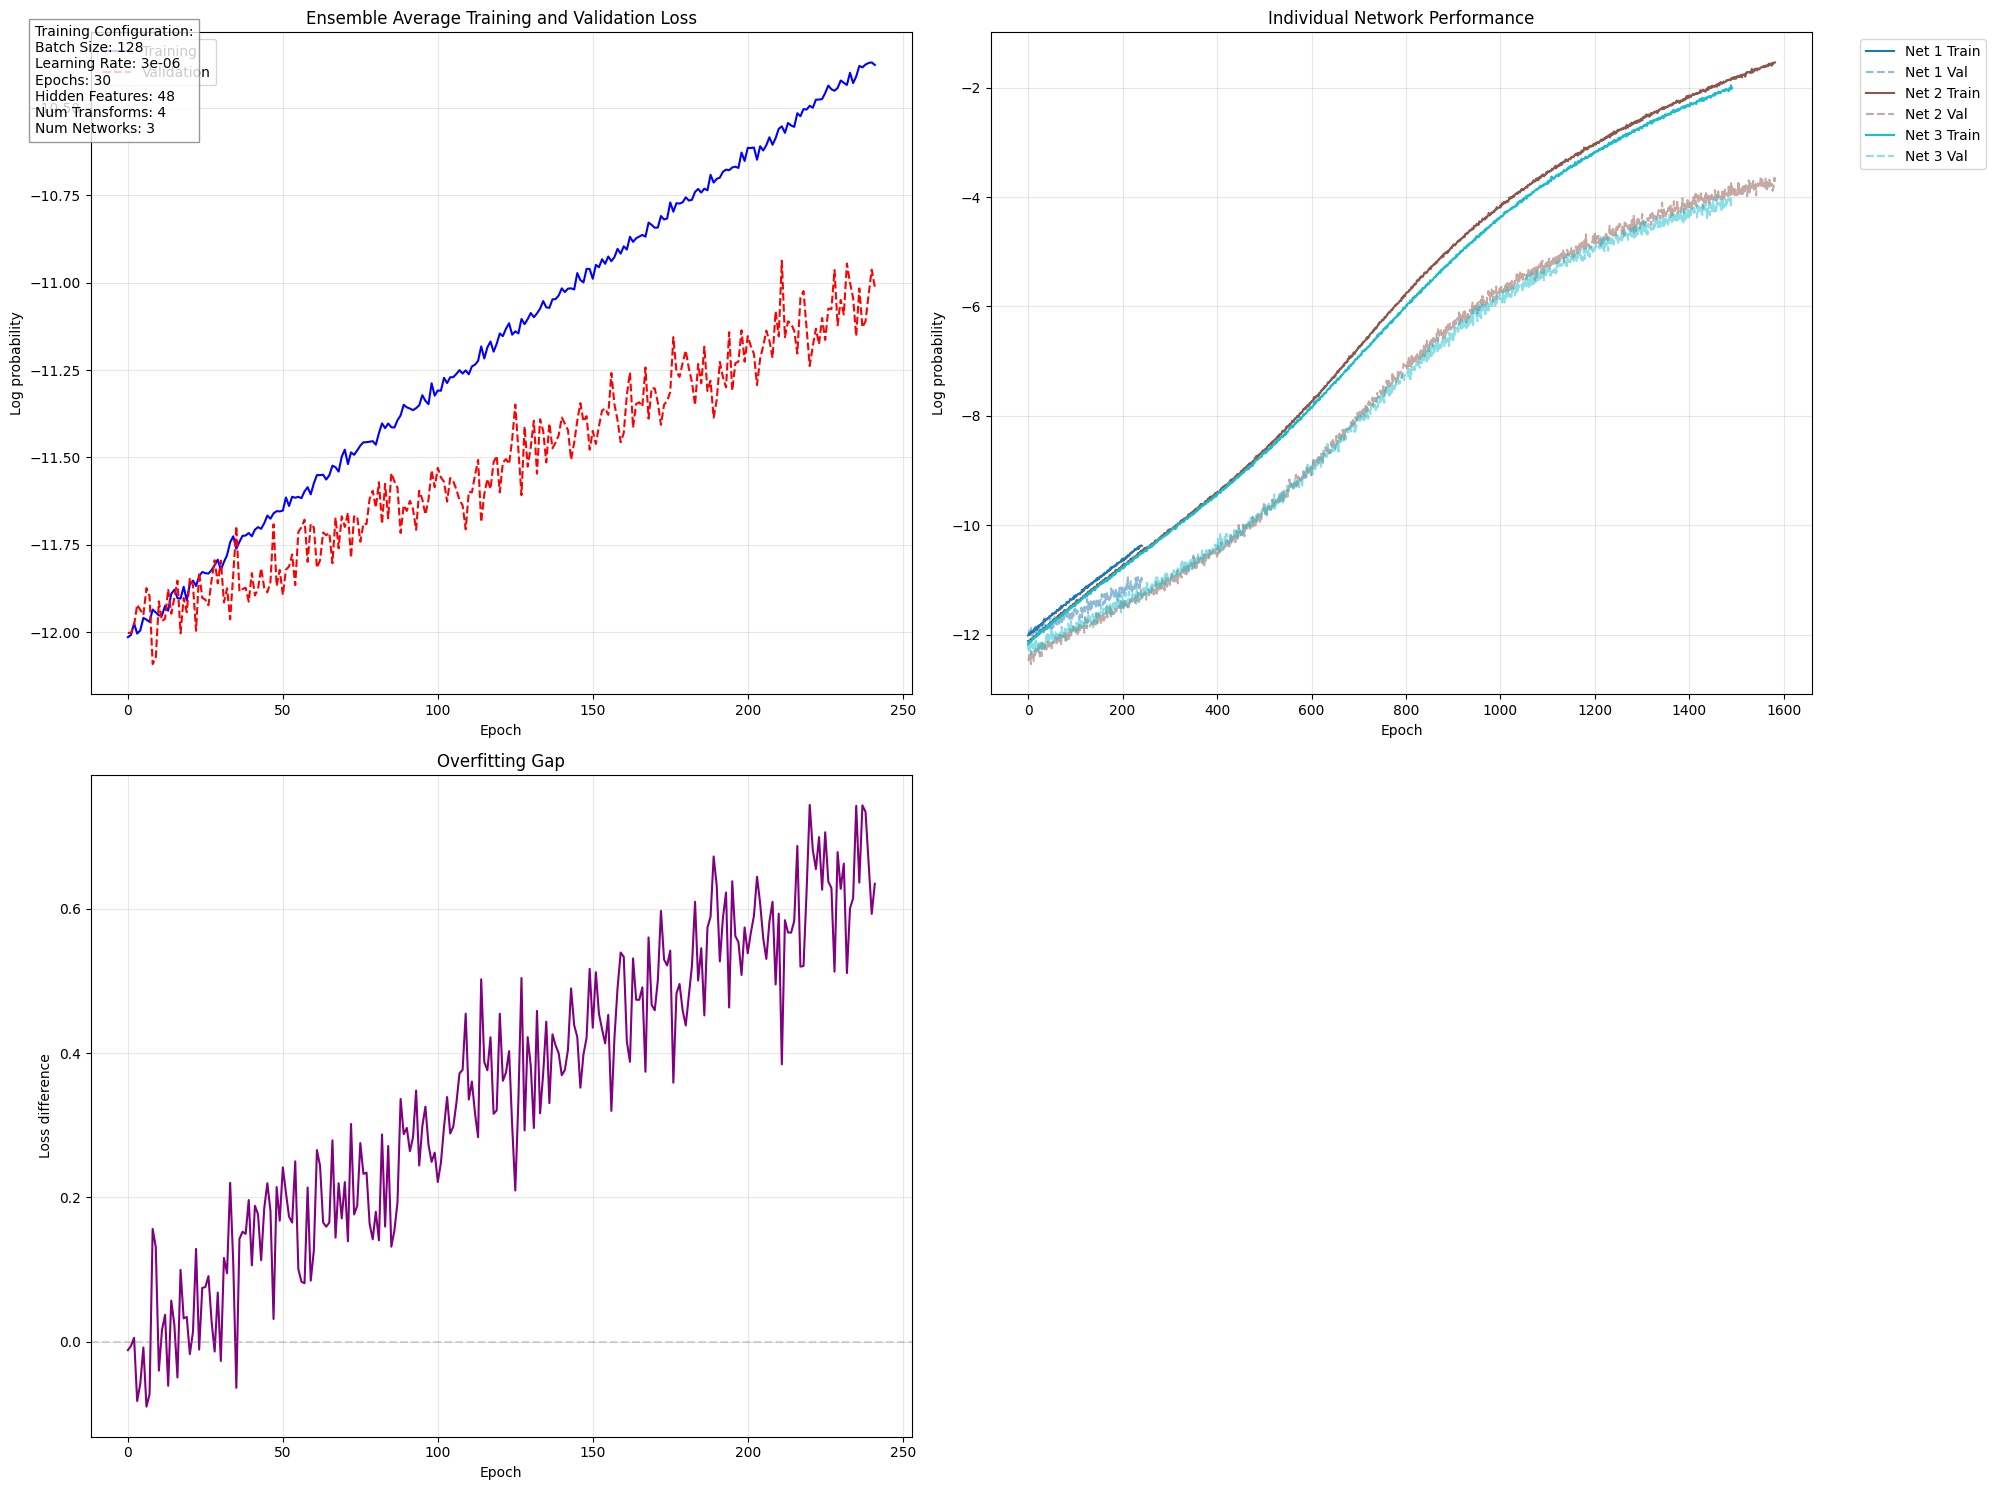

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 402 posterior samples:   0%|          | 0/402 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 387 posterior samples:   0%|          | 0/387 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 606 posterior samples:   0%|          | 0/606 [00:00<?, ?it/s]

Drawing 394 posterior samples:   0%|          | 0/394 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 396 posterior samples:   0%|          | 0/396 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 421 posterior samples:   0%|          | 0/421 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 563 posterior samples:   0%|          | 0/563 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 390 posterior samples:   0%|          | 0/390 [00:00<?, ?it/s]

Drawing 572 posterior samples:   0%|          | 0/572 [00:00<?, ?it/s]

Drawing 428 posterior samples:   0%|          | 0/428 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 606 posterior samples:   0%|          | 0/606 [00:00<?, ?it/s]

Drawing 393 posterior samples:   0%|          | 0/393 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 402 posterior samples:   0%|          | 0/402 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 559 posterior samples:   0%|          | 0/559 [00:00<?, ?it/s]

Drawing 440 posterior samples:   0%|          | 0/440 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 396 posterior samples:   0%|          | 0/396 [00:00<?, ?it/s]

Drawing 560 posterior samples:   0%|          | 0/560 [00:00<?, ?it/s]

Drawing 440 posterior samples:   0%|          | 0/440 [00:00<?, ?it/s]

Drawing 579 posterior samples:   0%|          | 0/579 [00:00<?, ?it/s]

Drawing 421 posterior samples:   0%|          | 0/421 [00:00<?, ?it/s]

Drawing 563 posterior samples:   0%|          | 0/563 [00:00<?, ?it/s]

Drawing 437 posterior samples:   0%|          | 0/437 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 604 posterior samples:   0%|          | 0/604 [00:00<?, ?it/s]

Drawing 396 posterior samples:   0%|          | 0/396 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 391 posterior samples:   0%|          | 0/391 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 592 posterior samples:   0%|          | 0/592 [00:00<?, ?it/s]

Drawing 408 posterior samples:   0%|          | 0/408 [00:00<?, ?it/s]

Drawing 595 posterior samples:   0%|          | 0/595 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 564 posterior samples:   0%|          | 0/564 [00:00<?, ?it/s]

Drawing 436 posterior samples:   0%|          | 0/436 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 378 posterior samples:   0%|          | 0/378 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 404 posterior samples:   0%|          | 0/404 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 403 posterior samples:   0%|          | 0/403 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 568 posterior samples:   0%|          | 0/568 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 421 posterior samples:   0%|          | 0/421 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 552 posterior samples:   0%|          | 0/552 [00:00<?, ?it/s]

Drawing 446 posterior samples:   0%|          | 0/446 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 402 posterior samples:   0%|          | 0/402 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 573 posterior samples:   0%|          | 0/573 [00:00<?, ?it/s]

Drawing 427 posterior samples:   0%|          | 0/427 [00:00<?, ?it/s]

Drawing 571 posterior samples:   0%|          | 0/571 [00:00<?, ?it/s]

Drawing 429 posterior samples:   0%|          | 0/429 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 404 posterior samples:   0%|          | 0/404 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 387 posterior samples:   0%|          | 0/387 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 392 posterior samples:   0%|          | 0/392 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 433 posterior samples:   0%|          | 0/433 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 569 posterior samples:   0%|          | 0/569 [00:00<?, ?it/s]

Drawing 431 posterior samples:   0%|          | 0/431 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 404 posterior samples:   0%|          | 0/404 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 570 posterior samples:   0%|          | 0/570 [00:00<?, ?it/s]

Drawing 429 posterior samples:   0%|          | 0/429 [00:00<?, ?it/s]

Drawing 601 posterior samples:   0%|          | 0/601 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 570 posterior samples:   0%|          | 0/570 [00:00<?, ?it/s]

Drawing 430 posterior samples:   0%|          | 0/430 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 568 posterior samples:   0%|          | 0/568 [00:00<?, ?it/s]

Drawing 430 posterior samples:   0%|          | 0/430 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 424 posterior samples:   0%|          | 0/424 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 402 posterior samples:   0%|          | 0/402 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 389 posterior samples:   0%|          | 0/389 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 416 posterior samples:   0%|          | 0/416 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 433 posterior samples:   0%|          | 0/433 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 569 posterior samples:   0%|          | 0/569 [00:00<?, ?it/s]

Drawing 431 posterior samples:   0%|          | 0/431 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 387 posterior samples:   0%|          | 0/387 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 393 posterior samples:   0%|          | 0/393 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 391 posterior samples:   0%|          | 0/391 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 561 posterior samples:   0%|          | 0/561 [00:00<?, ?it/s]

Drawing 439 posterior samples:   0%|          | 0/439 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 416 posterior samples:   0%|          | 0/416 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 573 posterior samples:   0%|          | 0/573 [00:00<?, ?it/s]

Drawing 427 posterior samples:   0%|          | 0/427 [00:00<?, ?it/s]

Drawing 573 posterior samples:   0%|          | 0/573 [00:00<?, ?it/s]

Drawing 427 posterior samples:   0%|          | 0/427 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 433 posterior samples:   0%|          | 0/433 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 400 posterior samples:   0%|          | 0/400 [00:00<?, ?it/s]

Drawing 568 posterior samples:   0%|          | 0/568 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 593 posterior samples:   0%|          | 0/593 [00:00<?, ?it/s]

Drawing 407 posterior samples:   0%|          | 0/407 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 398 posterior samples:   0%|          | 0/398 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 390 posterior samples:   0%|          | 0/390 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 604 posterior samples:   0%|          | 0/604 [00:00<?, ?it/s]

Drawing 396 posterior samples:   0%|          | 0/396 [00:00<?, ?it/s]

Drawing 550 posterior samples:   0%|          | 0/550 [00:00<?, ?it/s]

Drawing 450 posterior samples:   0%|          | 0/450 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 564 posterior samples:   0%|          | 0/564 [00:00<?, ?it/s]

Drawing 436 posterior samples:   0%|          | 0/436 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 569 posterior samples:   0%|          | 0/569 [00:00<?, ?it/s]

Drawing 431 posterior samples:   0%|          | 0/431 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 566 posterior samples:   0%|          | 0/566 [00:00<?, ?it/s]

Drawing 434 posterior samples:   0%|          | 0/434 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 402 posterior samples:   0%|          | 0/402 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 579 posterior samples:   0%|          | 0/579 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 400 posterior samples:   0%|          | 0/400 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 566 posterior samples:   0%|          | 0/566 [00:00<?, ?it/s]

Drawing 433 posterior samples:   0%|          | 0/433 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 571 posterior samples:   0%|          | 0/571 [00:00<?, ?it/s]

Drawing 429 posterior samples:   0%|          | 0/429 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 392 posterior samples:   0%|          | 0/392 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 424 posterior samples:   0%|          | 0/424 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 557 posterior samples:   0%|          | 0/557 [00:00<?, ?it/s]

Drawing 442 posterior samples:   0%|          | 0/442 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 386 posterior samples:   0%|          | 0/386 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 593 posterior samples:   0%|          | 0/593 [00:00<?, ?it/s]

Drawing 407 posterior samples:   0%|          | 0/407 [00:00<?, ?it/s]

Drawing 553 posterior samples:   0%|          | 0/553 [00:00<?, ?it/s]

Drawing 447 posterior samples:   0%|          | 0/447 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 433 posterior samples:   0%|          | 0/433 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 562 posterior samples:   0%|          | 0/562 [00:00<?, ?it/s]

Drawing 438 posterior samples:   0%|          | 0/438 [00:00<?, ?it/s]

Drawing 601 posterior samples:   0%|          | 0/601 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 601 posterior samples:   0%|          | 0/601 [00:00<?, ?it/s]

Drawing 398 posterior samples:   0%|          | 0/398 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 378 posterior samples:   0%|          | 0/378 [00:00<?, ?it/s]

Drawing 601 posterior samples:   0%|          | 0/601 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 592 posterior samples:   0%|          | 0/592 [00:00<?, ?it/s]

Drawing 407 posterior samples:   0%|          | 0/407 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 573 posterior samples:   0%|          | 0/573 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 563 posterior samples:   0%|          | 0/563 [00:00<?, ?it/s]

Drawing 437 posterior samples:   0%|          | 0/437 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 579 posterior samples:   0%|          | 0/579 [00:00<?, ?it/s]

Drawing 421 posterior samples:   0%|          | 0/421 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 568 posterior samples:   0%|          | 0/568 [00:00<?, ?it/s]

Drawing 431 posterior samples:   0%|          | 0/431 [00:00<?, ?it/s]

Drawing 597 posterior samples:   0%|          | 0/597 [00:00<?, ?it/s]

Drawing 403 posterior samples:   0%|          | 0/403 [00:00<?, ?it/s]

Drawing 602 posterior samples:   0%|          | 0/602 [00:00<?, ?it/s]

Drawing 398 posterior samples:   0%|          | 0/398 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 595 posterior samples:   0%|          | 0/595 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 592 posterior samples:   0%|          | 0/592 [00:00<?, ?it/s]

Drawing 408 posterior samples:   0%|          | 0/408 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 564 posterior samples:   0%|          | 0/564 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 569 posterior samples:   0%|          | 0/569 [00:00<?, ?it/s]

Drawing 430 posterior samples:   0%|          | 0/430 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 565 posterior samples:   0%|          | 0/565 [00:00<?, ?it/s]

Drawing 434 posterior samples:   0%|          | 0/434 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 571 posterior samples:   0%|          | 0/571 [00:00<?, ?it/s]

Drawing 428 posterior samples:   0%|          | 0/428 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 422 posterior samples:   0%|          | 0/422 [00:00<?, ?it/s]

Drawing 577 posterior samples:   0%|          | 0/577 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 395 posterior samples:   0%|          | 0/395 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 400 posterior samples:   0%|          | 0/400 [00:00<?, ?it/s]

Drawing 592 posterior samples:   0%|          | 0/592 [00:00<?, ?it/s]

Drawing 408 posterior samples:   0%|          | 0/408 [00:00<?, ?it/s]

Drawing 572 posterior samples:   0%|          | 0/572 [00:00<?, ?it/s]

Drawing 428 posterior samples:   0%|          | 0/428 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 579 posterior samples:   0%|          | 0/579 [00:00<?, ?it/s]

Drawing 421 posterior samples:   0%|          | 0/421 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 545 posterior samples:   0%|          | 0/545 [00:00<?, ?it/s]

Drawing 455 posterior samples:   0%|          | 0/455 [00:00<?, ?it/s]

Drawing 563 posterior samples:   0%|          | 0/563 [00:00<?, ?it/s]

Drawing 437 posterior samples:   0%|          | 0/437 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 416 posterior samples:   0%|          | 0/416 [00:00<?, ?it/s]

Drawing 613 posterior samples:   0%|          | 0/613 [00:00<?, ?it/s]

Drawing 387 posterior samples:   0%|          | 0/387 [00:00<?, ?it/s]

Updated parameter metrics for 28 parameters
INFO:training_monitor_IllustrisTNG_all_BC03_attenuated_13_13:Updated parameter metrics for 28 parameters


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 568 posterior samples:   0%|          | 0/568 [00:00<?, ?it/s]

Drawing 431 posterior samples:   0%|          | 0/431 [00:00<?, ?it/s]

Drawing 595 posterior samples:   0%|          | 0/595 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 549 posterior samples:   0%|          | 0/549 [00:00<?, ?it/s]

Drawing 451 posterior samples:   0%|          | 0/451 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 421 posterior samples:   0%|          | 0/421 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 391 posterior samples:   0%|          | 0/391 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 402 posterior samples:   0%|          | 0/402 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 368 posterior samples:   0%|          | 0/368 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 422 posterior samples:   0%|          | 0/422 [00:00<?, ?it/s]

Drawing 602 posterior samples:   0%|          | 0/602 [00:00<?, ?it/s]

Drawing 398 posterior samples:   0%|          | 0/398 [00:00<?, ?it/s]

Drawing 601 posterior samples:   0%|          | 0/601 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 424 posterior samples:   0%|          | 0/424 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 548 posterior samples:   0%|          | 0/548 [00:00<?, ?it/s]

Drawing 450 posterior samples:   0%|          | 0/450 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 433 posterior samples:   0%|          | 0/433 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 577 posterior samples:   0%|          | 0/577 [00:00<?, ?it/s]

Drawing 422 posterior samples:   0%|          | 0/422 [00:00<?, ?it/s]

Drawing 554 posterior samples:   0%|          | 0/554 [00:00<?, ?it/s]

Drawing 446 posterior samples:   0%|          | 0/446 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 573 posterior samples:   0%|          | 0/573 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 416 posterior samples:   0%|          | 0/416 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 386 posterior samples:   0%|          | 0/386 [00:00<?, ?it/s]

Drawing 564 posterior samples:   0%|          | 0/564 [00:00<?, ?it/s]

Drawing 436 posterior samples:   0%|          | 0/436 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 391 posterior samples:   0%|          | 0/391 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 573 posterior samples:   0%|          | 0/573 [00:00<?, ?it/s]

Drawing 427 posterior samples:   0%|          | 0/427 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 601 posterior samples:   0%|          | 0/601 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 566 posterior samples:   0%|          | 0/566 [00:00<?, ?it/s]

Drawing 434 posterior samples:   0%|          | 0/434 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 390 posterior samples:   0%|          | 0/390 [00:00<?, ?it/s]

Drawing 550 posterior samples:   0%|          | 0/550 [00:00<?, ?it/s]

Drawing 450 posterior samples:   0%|          | 0/450 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 573 posterior samples:   0%|          | 0/573 [00:00<?, ?it/s]

Drawing 427 posterior samples:   0%|          | 0/427 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 568 posterior samples:   0%|          | 0/568 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 433 posterior samples:   0%|          | 0/433 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 397 posterior samples:   0%|          | 0/397 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 610 posterior samples:   0%|          | 0/610 [00:00<?, ?it/s]

Drawing 390 posterior samples:   0%|          | 0/390 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 558 posterior samples:   0%|          | 0/558 [00:00<?, ?it/s]

Drawing 441 posterior samples:   0%|          | 0/441 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 604 posterior samples:   0%|          | 0/604 [00:00<?, ?it/s]

Drawing 396 posterior samples:   0%|          | 0/396 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 548 posterior samples:   0%|          | 0/548 [00:00<?, ?it/s]

Drawing 451 posterior samples:   0%|          | 0/451 [00:00<?, ?it/s]

Drawing 602 posterior samples:   0%|          | 0/602 [00:00<?, ?it/s]

Drawing 398 posterior samples:   0%|          | 0/398 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 400 posterior samples:   0%|          | 0/400 [00:00<?, ?it/s]

Drawing 3 posterior samples:   0%|          | 0/3 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 424 posterior samples:   0%|          | 0/424 [00:00<?, ?it/s]

Drawing 565 posterior samples:   0%|          | 0/565 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 389 posterior samples:   0%|          | 0/389 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 408 posterior samples:   0%|          | 0/408 [00:00<?, ?it/s]

Drawing 595 posterior samples:   0%|          | 0/595 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 565 posterior samples:   0%|          | 0/565 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 424 posterior samples:   0%|          | 0/424 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 433 posterior samples:   0%|          | 0/433 [00:00<?, ?it/s]

Drawing 615 posterior samples:   0%|          | 0/615 [00:00<?, ?it/s]

Drawing 385 posterior samples:   0%|          | 0/385 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 389 posterior samples:   0%|          | 0/389 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 572 posterior samples:   0%|          | 0/572 [00:00<?, ?it/s]

Drawing 427 posterior samples:   0%|          | 0/427 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 559 posterior samples:   0%|          | 0/559 [00:00<?, ?it/s]

Drawing 440 posterior samples:   0%|          | 0/440 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 393 posterior samples:   0%|          | 0/393 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 422 posterior samples:   0%|          | 0/422 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 597 posterior samples:   0%|          | 0/597 [00:00<?, ?it/s]

Drawing 403 posterior samples:   0%|          | 0/403 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 388 posterior samples:   0%|          | 0/388 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 570 posterior samples:   0%|          | 0/570 [00:00<?, ?it/s]

Drawing 428 posterior samples:   0%|          | 0/428 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 407 posterior samples:   0%|          | 0/407 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 392 posterior samples:   0%|          | 0/392 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 416 posterior samples:   0%|          | 0/416 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 389 posterior samples:   0%|          | 0/389 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 416 posterior samples:   0%|          | 0/416 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 608 posterior samples:   0%|          | 0/608 [00:00<?, ?it/s]

Drawing 392 posterior samples:   0%|          | 0/392 [00:00<?, ?it/s]

Drawing 560 posterior samples:   0%|          | 0/560 [00:00<?, ?it/s]

Drawing 440 posterior samples:   0%|          | 0/440 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 433 posterior samples:   0%|          | 0/433 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 416 posterior samples:   0%|          | 0/416 [00:00<?, ?it/s]

Drawing 556 posterior samples:   0%|          | 0/556 [00:00<?, ?it/s]

Drawing 444 posterior samples:   0%|          | 0/444 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 554 posterior samples:   0%|          | 0/554 [00:00<?, ?it/s]

Drawing 444 posterior samples:   0%|          | 0/444 [00:00<?, ?it/s]

Drawing 572 posterior samples:   0%|          | 0/572 [00:00<?, ?it/s]

Drawing 428 posterior samples:   0%|          | 0/428 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 408 posterior samples:   0%|          | 0/408 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 404 posterior samples:   0%|          | 0/404 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 395 posterior samples:   0%|          | 0/395 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 374 posterior samples:   0%|          | 0/374 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 400 posterior samples:   0%|          | 0/400 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 608 posterior samples:   0%|          | 0/608 [00:00<?, ?it/s]

Drawing 392 posterior samples:   0%|          | 0/392 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 403 posterior samples:   0%|          | 0/403 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 571 posterior samples:   0%|          | 0/571 [00:00<?, ?it/s]

Drawing 428 posterior samples:   0%|          | 0/428 [00:00<?, ?it/s]

Drawing 592 posterior samples:   0%|          | 0/592 [00:00<?, ?it/s]

Drawing 408 posterior samples:   0%|          | 0/408 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 422 posterior samples:   0%|          | 0/422 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 394 posterior samples:   0%|          | 0/394 [00:00<?, ?it/s]

Drawing 577 posterior samples:   0%|          | 0/577 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 397 posterior samples:   0%|          | 0/397 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 389 posterior samples:   0%|          | 0/389 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 404 posterior samples:   0%|          | 0/404 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 404 posterior samples:   0%|          | 0/404 [00:00<?, ?it/s]

Drawing 558 posterior samples:   0%|          | 0/558 [00:00<?, ?it/s]

Drawing 442 posterior samples:   0%|          | 0/442 [00:00<?, ?it/s]

Drawing 573 posterior samples:   0%|          | 0/573 [00:00<?, ?it/s]

Drawing 427 posterior samples:   0%|          | 0/427 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 424 posterior samples:   0%|          | 0/424 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 3 posterior samples:   0%|          | 0/3 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 422 posterior samples:   0%|          | 0/422 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 3 posterior samples:   0%|          | 0/3 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 392 posterior samples:   0%|          | 0/392 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 601 posterior samples:   0%|          | 0/601 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 563 posterior samples:   0%|          | 0/563 [00:00<?, ?it/s]

Drawing 437 posterior samples:   0%|          | 0/437 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 604 posterior samples:   0%|          | 0/604 [00:00<?, ?it/s]

Drawing 395 posterior samples:   0%|          | 0/395 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 560 posterior samples:   0%|          | 0/560 [00:00<?, ?it/s]

Drawing 440 posterior samples:   0%|          | 0/440 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 422 posterior samples:   0%|          | 0/422 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 597 posterior samples:   0%|          | 0/597 [00:00<?, ?it/s]

Drawing 403 posterior samples:   0%|          | 0/403 [00:00<?, ?it/s]

Drawing 573 posterior samples:   0%|          | 0/573 [00:00<?, ?it/s]

Drawing 427 posterior samples:   0%|          | 0/427 [00:00<?, ?it/s]

Drawing 579 posterior samples:   0%|          | 0/579 [00:00<?, ?it/s]

Drawing 421 posterior samples:   0%|          | 0/421 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 569 posterior samples:   0%|          | 0/569 [00:00<?, ?it/s]

Drawing 430 posterior samples:   0%|          | 0/430 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 424 posterior samples:   0%|          | 0/424 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 384 posterior samples:   0%|          | 0/384 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 604 posterior samples:   0%|          | 0/604 [00:00<?, ?it/s]

Drawing 395 posterior samples:   0%|          | 0/395 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 569 posterior samples:   0%|          | 0/569 [00:00<?, ?it/s]

Drawing 430 posterior samples:   0%|          | 0/430 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 384 posterior samples:   0%|          | 0/384 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 579 posterior samples:   0%|          | 0/579 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 552 posterior samples:   0%|          | 0/552 [00:00<?, ?it/s]

Drawing 446 posterior samples:   0%|          | 0/446 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 571 posterior samples:   0%|          | 0/571 [00:00<?, ?it/s]

Drawing 428 posterior samples:   0%|          | 0/428 [00:00<?, ?it/s]

Drawing 569 posterior samples:   0%|          | 0/569 [00:00<?, ?it/s]

Drawing 431 posterior samples:   0%|          | 0/431 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 569 posterior samples:   0%|          | 0/569 [00:00<?, ?it/s]

Drawing 430 posterior samples:   0%|          | 0/430 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 400 posterior samples:   0%|          | 0/400 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 565 posterior samples:   0%|          | 0/565 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 573 posterior samples:   0%|          | 0/573 [00:00<?, ?it/s]

Drawing 427 posterior samples:   0%|          | 0/427 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 610 posterior samples:   0%|          | 0/610 [00:00<?, ?it/s]

Drawing 389 posterior samples:   0%|          | 0/389 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 424 posterior samples:   0%|          | 0/424 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 397 posterior samples:   0%|          | 0/397 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 3 posterior samples:   0%|          | 0/3 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 416 posterior samples:   0%|          | 0/416 [00:00<?, ?it/s]

Drawing 564 posterior samples:   0%|          | 0/564 [00:00<?, ?it/s]

Drawing 436 posterior samples:   0%|          | 0/436 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 561 posterior samples:   0%|          | 0/561 [00:00<?, ?it/s]

Drawing 437 posterior samples:   0%|          | 0/437 [00:00<?, ?it/s]

/tmp/ipykernel_1700251/2212895014.py:233: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(
Saved parameter predictions plot to /disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only//posterior_predictions_bs128_lr3e-06_hf48_nt4.png
INFO:training_monitor_IllustrisTNG_all_BC03_attenuated_13_13:Saved parameter predictions plot to /disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only//posterior_predictions_bs128_lr3e-06_hf48_nt4.png


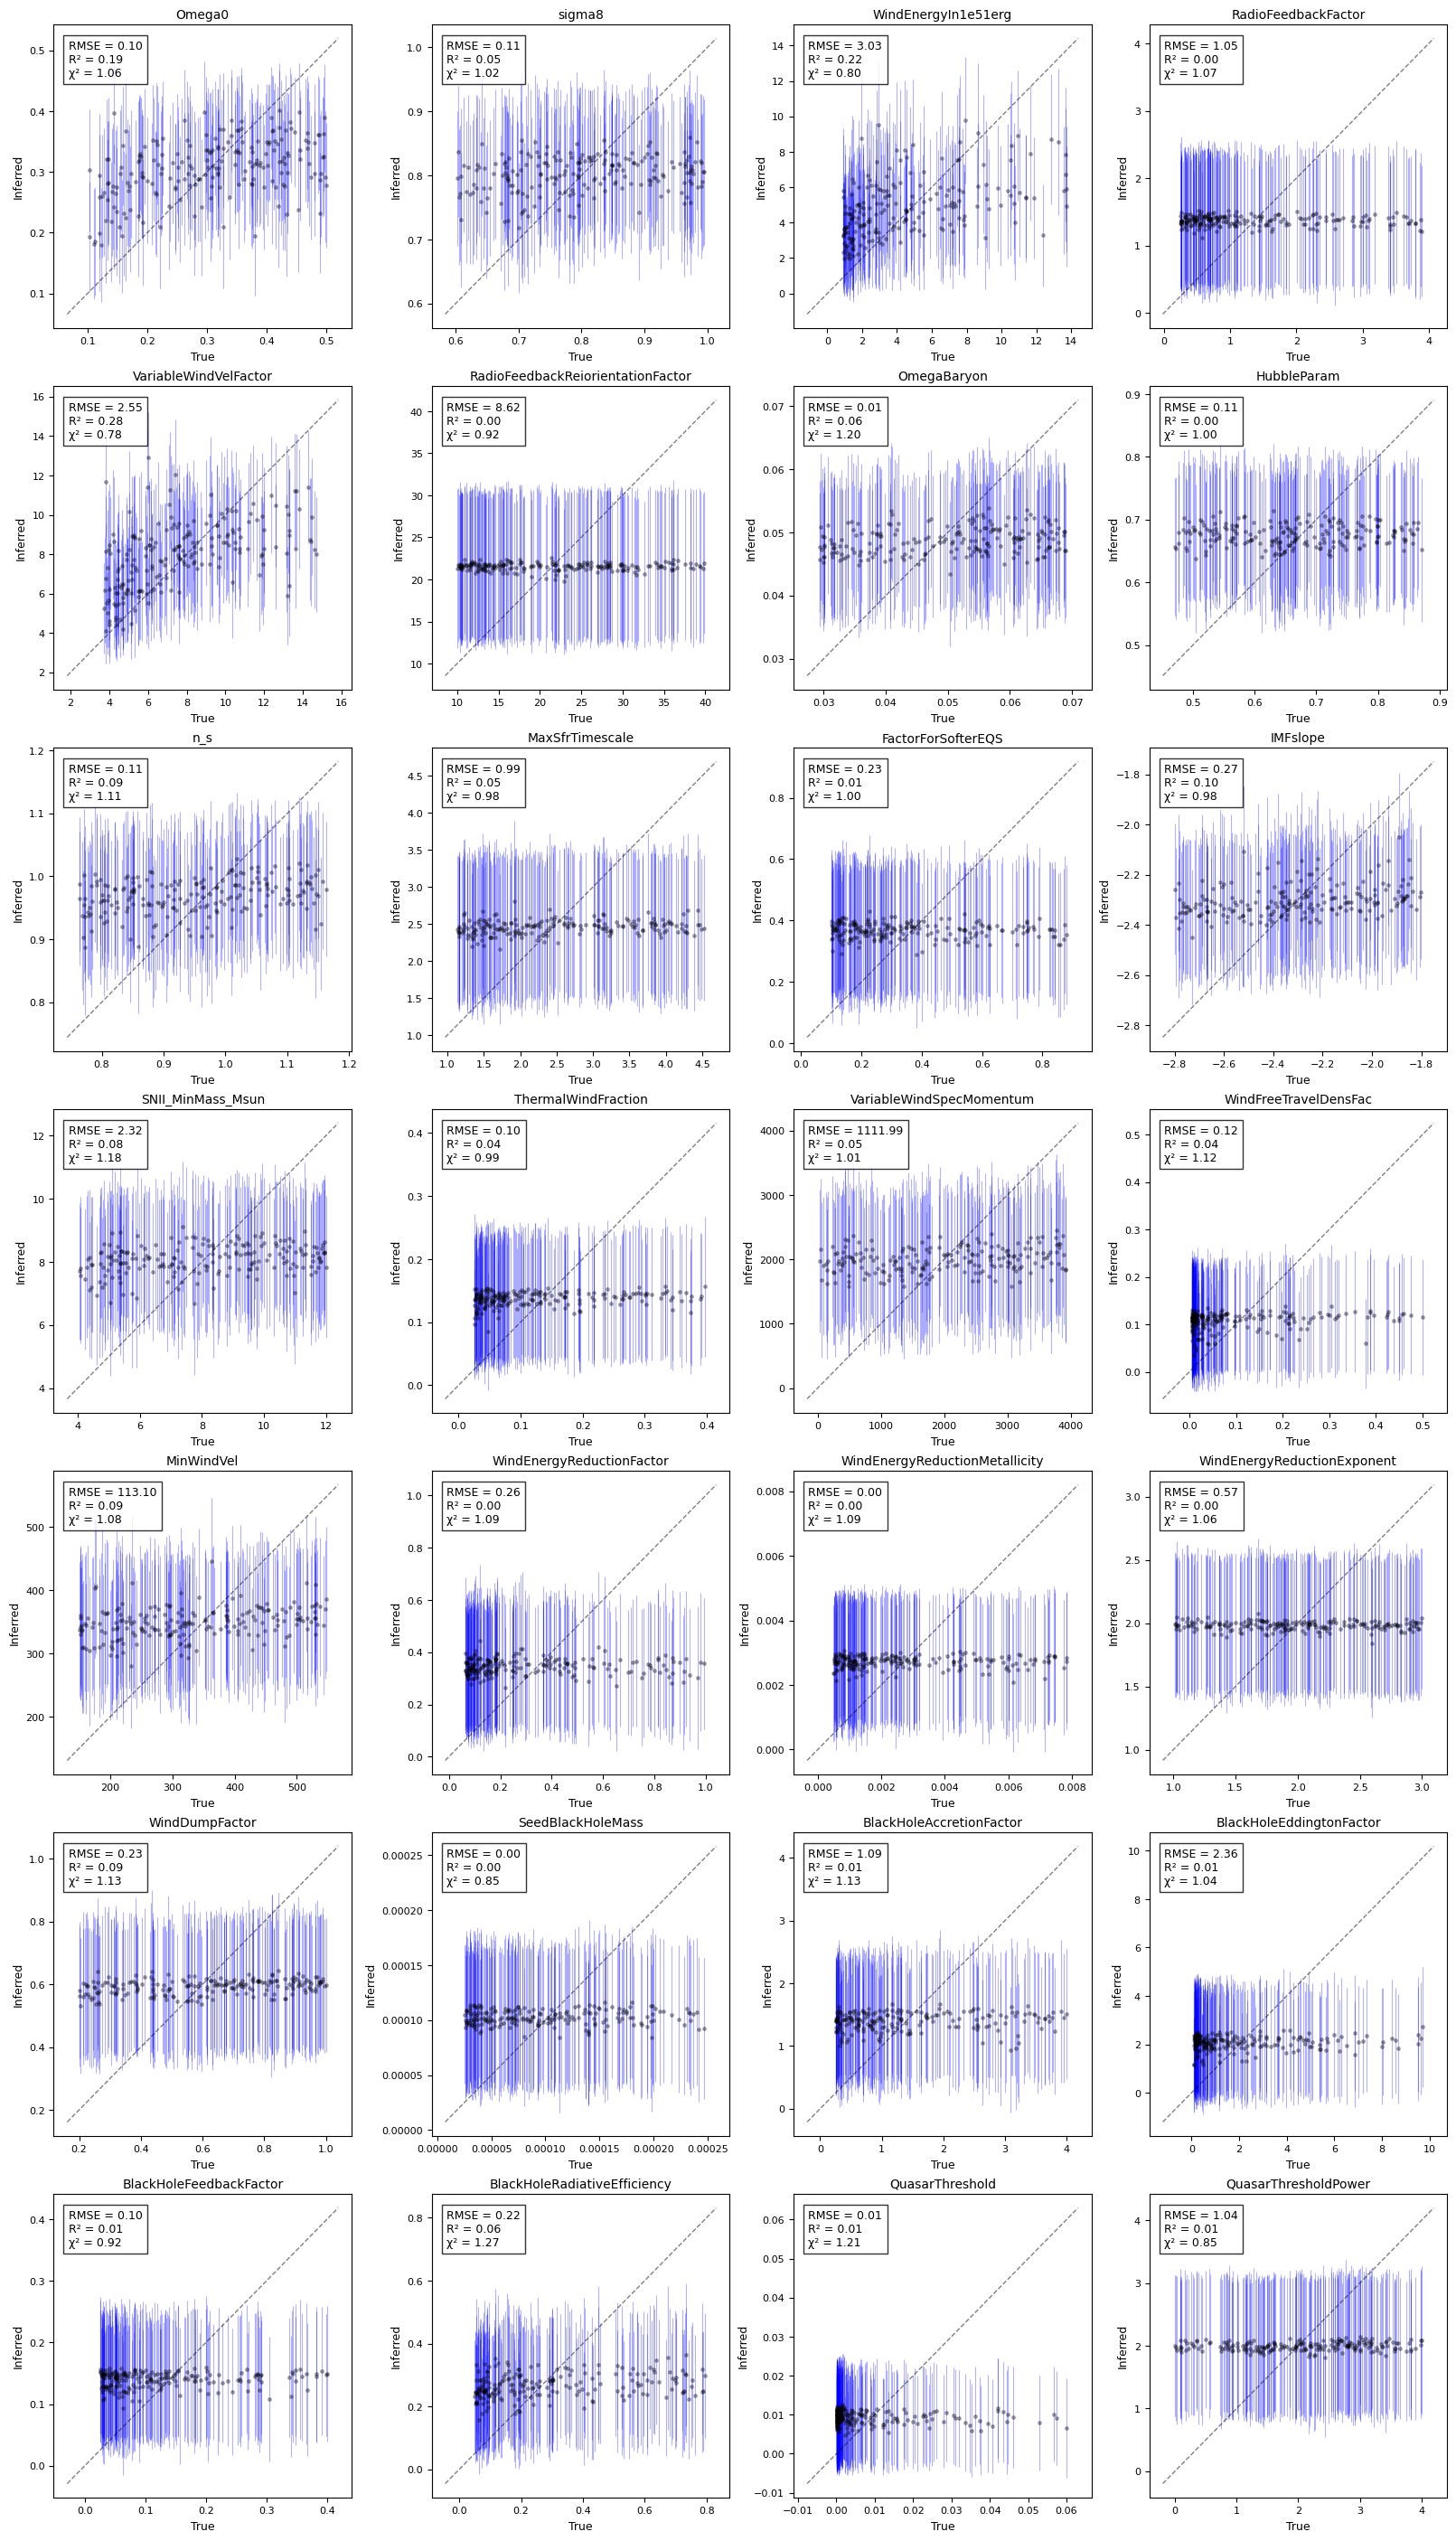

AttributeError: 'TrainingMonitor' object has no attribute 'plot_coverage_analysis'

In [19]:
# Generate diagnostic plots
config_str = f"bs{train_args['training_batch_size']}_lr{train_args['learning_rate']:.0e}_hf{hidden_features}_nt{num_transforms}"

# First update the metrics from training
monitor.update_metrics(summaries)


In [9]:
posterior_ensemble

NeuralPosteriorEnsemble sampler for potential_fn=<EnsemblePotential>

In [10]:
summaries

[{'epochs_trained': [0, 1546],
  'best_validation_log_prob': [-inf, -3.7576675415039062],
  'validation_log_probs': [-12.298744678497314,
   -12.334815979003906,
   -12.240913391113281,
   -12.344161987304688,
   -12.304842948913574,
   -12.32701063156128,
   -12.311384201049805,
   -12.376935958862305,
   -12.23773717880249,
   -12.300164699554443,
   -12.28202199935913,
   -12.2016921043396,
   -12.299333572387695,
   -12.299659729003906,
   -12.108760833740234,
   -12.218969345092773,
   -12.307255744934082,
   -12.224556922912598,
   -12.218142032623291,
   -12.088058948516846,
   -12.23081636428833,
   -12.20887804031372,
   -12.314334392547607,
   -12.191156387329102,
   -12.192645072937012,
   -12.199363231658936,
   -12.186544418334961,
   -12.122953414916992,
   -12.160410404205322,
   -12.0871901512146,
   -12.156129360198975,
   -12.146315574645996,
   -12.191720008850098,
   -12.229913711547852,
   -12.170389175415039,
   -12.055790424346924,
   -12.191461563110352,
   -12.

In [11]:
print("training_batch_size", train_args[ "training_batch_size"])
print("learning_rate", train_args[ "learning_rate"])
print("stop_after_epochs", train_args[ "stop_after_epochs"])
# print("validation_fraction", train_args[ "validation_fraction"])
print("hidden_features", hidden_features)
print("num_transforms", num_transforms)
print("num_nets", num_nets)



training_batch_size 128
learning_rate 3e-06
stop_after_epochs 30
hidden_features 48
num_transforms 4
num_nets 1


/tmp/ipykernel_1700251/1704394111.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


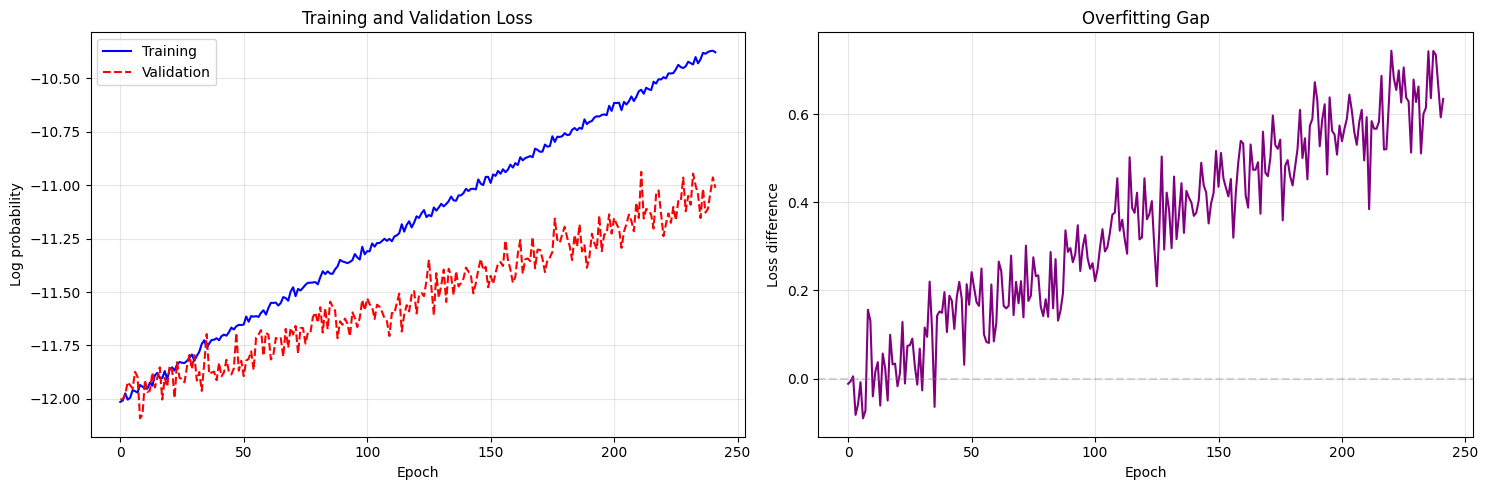

In [21]:
def plot_training_diagnostics(summaries):
    """Plot training diagnostics without empty subplots"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Changed to 1 row, 2 columns
    
    # Loss curves
    train_losses = summaries[0]['training_log_probs']
    val_losses = summaries[0]['validation_log_probs']
    epochs = range(len(train_losses))
    
    ax1.plot(epochs, train_losses, '-', label='Training', color='blue')
    ax1.plot(epochs, val_losses, '--', label='Validation', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Log probability')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Overfitting gap
    gap = np.array(train_losses) - np.array(val_losses)
    ax2.plot(epochs, gap, '-', color='purple')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss difference')
    ax2.set_title('Overfitting Gap')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# refer back to training args in file name
model_params = f"batch{train_args['training_batch_size']}_" \
               f"lr{train_args['learning_rate']:.0e}_" \
               f"epochs{train_args['stop_after_epochs']}_" \
               f"val{train_args['validation_fraction']}_" \
               f"hidden{hidden_features}_" \
               f"transforms{num_transforms}"

# Use the function
fig = plot_training_diagnostics(summaries)
plt.savefig(os.path.join(plots_out_dir, f'loss_overfitting_{model_params}.png'))
plt.show()
plt.close()

In [13]:

# # Get test data
# x_test = x_all[test_mask]
# theta_test = theta[test_mask]

# # get train data
# x_train=x_all[train_mask].clone().detach(),
# theta_train=theta[train_mask].clone().detach()


### Drawing samples from the entire test set to look at overall performance of the model

Drawing 3 posterior samples:   0%|          | 0/3 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 408 posterior samples:   0%|          | 0/408 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 606 posterior samples:   0%|          | 0/606 [00:00<?, ?it/s]

Drawing 393 posterior samples:   0%|          | 0/393 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 597 posterior samples:   0%|          | 0/597 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 577 posterior samples:   0%|          | 0/577 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 380 posterior samples:   0%|          | 0/380 [00:00<?, ?it/s]

Drawing 571 posterior samples:   0%|          | 0/571 [00:00<?, ?it/s]

Drawing 429 posterior samples:   0%|          | 0/429 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 402 posterior samples:   0%|          | 0/402 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 606 posterior samples:   0%|          | 0/606 [00:00<?, ?it/s]

Drawing 392 posterior samples:   0%|          | 0/392 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 577 posterior samples:   0%|          | 0/577 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 593 posterior samples:   0%|          | 0/593 [00:00<?, ?it/s]

Drawing 407 posterior samples:   0%|          | 0/407 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 422 posterior samples:   0%|          | 0/422 [00:00<?, ?it/s]

Drawing 555 posterior samples:   0%|          | 0/555 [00:00<?, ?it/s]

Drawing 445 posterior samples:   0%|          | 0/445 [00:00<?, ?it/s]

Drawing 595 posterior samples:   0%|          | 0/595 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 592 posterior samples:   0%|          | 0/592 [00:00<?, ?it/s]

Drawing 407 posterior samples:   0%|          | 0/407 [00:00<?, ?it/s]

Drawing 601 posterior samples:   0%|          | 0/601 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 604 posterior samples:   0%|          | 0/604 [00:00<?, ?it/s]

Drawing 396 posterior samples:   0%|          | 0/396 [00:00<?, ?it/s]

Drawing 593 posterior samples:   0%|          | 0/593 [00:00<?, ?it/s]

Drawing 407 posterior samples:   0%|          | 0/407 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 566 posterior samples:   0%|          | 0/566 [00:00<?, ?it/s]

Drawing 433 posterior samples:   0%|          | 0/433 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 597 posterior samples:   0%|          | 0/597 [00:00<?, ?it/s]

Drawing 403 posterior samples:   0%|          | 0/403 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 377 posterior samples:   0%|          | 0/377 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 563 posterior samples:   0%|          | 0/563 [00:00<?, ?it/s]

Drawing 436 posterior samples:   0%|          | 0/436 [00:00<?, ?it/s]

Drawing 592 posterior samples:   0%|          | 0/592 [00:00<?, ?it/s]

Drawing 408 posterior samples:   0%|          | 0/408 [00:00<?, ?it/s]

Drawing 570 posterior samples:   0%|          | 0/570 [00:00<?, ?it/s]

Drawing 430 posterior samples:   0%|          | 0/430 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 558 posterior samples:   0%|          | 0/558 [00:00<?, ?it/s]

Drawing 442 posterior samples:   0%|          | 0/442 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 433 posterior samples:   0%|          | 0/433 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 558 posterior samples:   0%|          | 0/558 [00:00<?, ?it/s]

Drawing 441 posterior samples:   0%|          | 0/441 [00:00<?, ?it/s]

Drawing 566 posterior samples:   0%|          | 0/566 [00:00<?, ?it/s]

Drawing 434 posterior samples:   0%|          | 0/434 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 570 posterior samples:   0%|          | 0/570 [00:00<?, ?it/s]

Drawing 429 posterior samples:   0%|          | 0/429 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 602 posterior samples:   0%|          | 0/602 [00:00<?, ?it/s]

Drawing 397 posterior samples:   0%|          | 0/397 [00:00<?, ?it/s]

Drawing 619 posterior samples:   0%|          | 0/619 [00:00<?, ?it/s]

Drawing 381 posterior samples:   0%|          | 0/381 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 381 posterior samples:   0%|          | 0/381 [00:00<?, ?it/s]

Drawing 566 posterior samples:   0%|          | 0/566 [00:00<?, ?it/s]

Drawing 434 posterior samples:   0%|          | 0/434 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 416 posterior samples:   0%|          | 0/416 [00:00<?, ?it/s]

Drawing 577 posterior samples:   0%|          | 0/577 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 402 posterior samples:   0%|          | 0/402 [00:00<?, ?it/s]

Drawing 561 posterior samples:   0%|          | 0/561 [00:00<?, ?it/s]

Drawing 439 posterior samples:   0%|          | 0/439 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 410 posterior samples:   0%|          | 0/410 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 392 posterior samples:   0%|          | 0/392 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 404 posterior samples:   0%|          | 0/404 [00:00<?, ?it/s]

Drawing 592 posterior samples:   0%|          | 0/592 [00:00<?, ?it/s]

Drawing 408 posterior samples:   0%|          | 0/408 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 397 posterior samples:   0%|          | 0/397 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 400 posterior samples:   0%|          | 0/400 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 382 posterior samples:   0%|          | 0/382 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 579 posterior samples:   0%|          | 0/579 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 393 posterior samples:   0%|          | 0/393 [00:00<?, ?it/s]

Drawing 563 posterior samples:   0%|          | 0/563 [00:00<?, ?it/s]

Drawing 437 posterior samples:   0%|          | 0/437 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 388 posterior samples:   0%|          | 0/388 [00:00<?, ?it/s]

Drawing 3 posterior samples:   0%|          | 0/3 [00:00<?, ?it/s]

Drawing 593 posterior samples:   0%|          | 0/593 [00:00<?, ?it/s]

Drawing 404 posterior samples:   0%|          | 0/404 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 592 posterior samples:   0%|          | 0/592 [00:00<?, ?it/s]

Drawing 408 posterior samples:   0%|          | 0/408 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 400 posterior samples:   0%|          | 0/400 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 593 posterior samples:   0%|          | 0/593 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 601 posterior samples:   0%|          | 0/601 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 569 posterior samples:   0%|          | 0/569 [00:00<?, ?it/s]

Drawing 431 posterior samples:   0%|          | 0/431 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 424 posterior samples:   0%|          | 0/424 [00:00<?, ?it/s]

Drawing 544 posterior samples:   0%|          | 0/544 [00:00<?, ?it/s]

Drawing 456 posterior samples:   0%|          | 0/456 [00:00<?, ?it/s]

Drawing 595 posterior samples:   0%|          | 0/595 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 569 posterior samples:   0%|          | 0/569 [00:00<?, ?it/s]

Drawing 430 posterior samples:   0%|          | 0/430 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 570 posterior samples:   0%|          | 0/570 [00:00<?, ?it/s]

Drawing 430 posterior samples:   0%|          | 0/430 [00:00<?, ?it/s]

Drawing 571 posterior samples:   0%|          | 0/571 [00:00<?, ?it/s]

Drawing 429 posterior samples:   0%|          | 0/429 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 404 posterior samples:   0%|          | 0/404 [00:00<?, ?it/s]

Drawing 585 posterior samples:   0%|          | 0/585 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 570 posterior samples:   0%|          | 0/570 [00:00<?, ?it/s]

Drawing 430 posterior samples:   0%|          | 0/430 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 579 posterior samples:   0%|          | 0/579 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 566 posterior samples:   0%|          | 0/566 [00:00<?, ?it/s]

Drawing 434 posterior samples:   0%|          | 0/434 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 593 posterior samples:   0%|          | 0/593 [00:00<?, ?it/s]

Drawing 407 posterior samples:   0%|          | 0/407 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 601 posterior samples:   0%|          | 0/601 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 608 posterior samples:   0%|          | 0/608 [00:00<?, ?it/s]

Drawing 392 posterior samples:   0%|          | 0/392 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 422 posterior samples:   0%|          | 0/422 [00:00<?, ?it/s]

Drawing 608 posterior samples:   0%|          | 0/608 [00:00<?, ?it/s]

Drawing 392 posterior samples:   0%|          | 0/392 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 422 posterior samples:   0%|          | 0/422 [00:00<?, ?it/s]

Drawing 560 posterior samples:   0%|          | 0/560 [00:00<?, ?it/s]

Drawing 440 posterior samples:   0%|          | 0/440 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 565 posterior samples:   0%|          | 0/565 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 394 posterior samples:   0%|          | 0/394 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 555 posterior samples:   0%|          | 0/555 [00:00<?, ?it/s]

Drawing 444 posterior samples:   0%|          | 0/444 [00:00<?, ?it/s]

Drawing 559 posterior samples:   0%|          | 0/559 [00:00<?, ?it/s]

Drawing 441 posterior samples:   0%|          | 0/441 [00:00<?, ?it/s]

Drawing 576 posterior samples:   0%|          | 0/576 [00:00<?, ?it/s]

Drawing 424 posterior samples:   0%|          | 0/424 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 413 posterior samples:   0%|          | 0/413 [00:00<?, ?it/s]

Drawing 597 posterior samples:   0%|          | 0/597 [00:00<?, ?it/s]

Drawing 403 posterior samples:   0%|          | 0/403 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 384 posterior samples:   0%|          | 0/384 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 391 posterior samples:   0%|          | 0/391 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 383 posterior samples:   0%|          | 0/383 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 382 posterior samples:   0%|          | 0/382 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 391 posterior samples:   0%|          | 0/391 [00:00<?, ?it/s]

Drawing 568 posterior samples:   0%|          | 0/568 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 371 posterior samples:   0%|          | 0/371 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 619 posterior samples:   0%|          | 0/619 [00:00<?, ?it/s]

Drawing 379 posterior samples:   0%|          | 0/379 [00:00<?, ?it/s]

Drawing 571 posterior samples:   0%|          | 0/571 [00:00<?, ?it/s]

Drawing 429 posterior samples:   0%|          | 0/429 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 559 posterior samples:   0%|          | 0/559 [00:00<?, ?it/s]

Drawing 441 posterior samples:   0%|          | 0/441 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 580 posterior samples:   0%|          | 0/580 [00:00<?, ?it/s]

Drawing 420 posterior samples:   0%|          | 0/420 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 400 posterior samples:   0%|          | 0/400 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 412 posterior samples:   0%|          | 0/412 [00:00<?, ?it/s]

Drawing 597 posterior samples:   0%|          | 0/597 [00:00<?, ?it/s]

Drawing 403 posterior samples:   0%|          | 0/403 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 404 posterior samples:   0%|          | 0/404 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 577 posterior samples:   0%|          | 0/577 [00:00<?, ?it/s]

Drawing 422 posterior samples:   0%|          | 0/422 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 590 posterior samples:   0%|          | 0/590 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 577 posterior samples:   0%|          | 0/577 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 559 posterior samples:   0%|          | 0/559 [00:00<?, ?it/s]

Drawing 441 posterior samples:   0%|          | 0/441 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 404 posterior samples:   0%|          | 0/404 [00:00<?, ?it/s]

Drawing 581 posterior samples:   0%|          | 0/581 [00:00<?, ?it/s]

Drawing 419 posterior samples:   0%|          | 0/419 [00:00<?, ?it/s]

Drawing 583 posterior samples:   0%|          | 0/583 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 407 posterior samples:   0%|          | 0/407 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 387 posterior samples:   0%|          | 0/387 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 411 posterior samples:   0%|          | 0/411 [00:00<?, ?it/s]

Drawing 572 posterior samples:   0%|          | 0/572 [00:00<?, ?it/s]

Drawing 428 posterior samples:   0%|          | 0/428 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 592 posterior samples:   0%|          | 0/592 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 380 posterior samples:   0%|          | 0/380 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 393 posterior samples:   0%|          | 0/393 [00:00<?, ?it/s]

Drawing 566 posterior samples:   0%|          | 0/566 [00:00<?, ?it/s]

Drawing 434 posterior samples:   0%|          | 0/434 [00:00<?, ?it/s]

Drawing 608 posterior samples:   0%|          | 0/608 [00:00<?, ?it/s]

Drawing 392 posterior samples:   0%|          | 0/392 [00:00<?, ?it/s]

Drawing 563 posterior samples:   0%|          | 0/563 [00:00<?, ?it/s]

Drawing 437 posterior samples:   0%|          | 0/437 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 416 posterior samples:   0%|          | 0/416 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 557 posterior samples:   0%|          | 0/557 [00:00<?, ?it/s]

Drawing 442 posterior samples:   0%|          | 0/442 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 606 posterior samples:   0%|          | 0/606 [00:00<?, ?it/s]

Drawing 393 posterior samples:   0%|          | 0/393 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 584 posterior samples:   0%|          | 0/584 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 564 posterior samples:   0%|          | 0/564 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 567 posterior samples:   0%|          | 0/567 [00:00<?, ?it/s]

Drawing 433 posterior samples:   0%|          | 0/433 [00:00<?, ?it/s]

Drawing 573 posterior samples:   0%|          | 0/573 [00:00<?, ?it/s]

Drawing 427 posterior samples:   0%|          | 0/427 [00:00<?, ?it/s]

Drawing 579 posterior samples:   0%|          | 0/579 [00:00<?, ?it/s]

Drawing 421 posterior samples:   0%|          | 0/421 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 575 posterior samples:   0%|          | 0/575 [00:00<?, ?it/s]

Drawing 425 posterior samples:   0%|          | 0/425 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 418 posterior samples:   0%|          | 0/418 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 559 posterior samples:   0%|          | 0/559 [00:00<?, ?it/s]

Drawing 440 posterior samples:   0%|          | 0/440 [00:00<?, ?it/s]

Drawing 597 posterior samples:   0%|          | 0/597 [00:00<?, ?it/s]

Drawing 403 posterior samples:   0%|          | 0/403 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 566 posterior samples:   0%|          | 0/566 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

Drawing 577 posterior samples:   0%|          | 0/577 [00:00<?, ?it/s]

Drawing 421 posterior samples:   0%|          | 0/421 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 402 posterior samples:   0%|          | 0/402 [00:00<?, ?it/s]

Drawing 568 posterior samples:   0%|          | 0/568 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 577 posterior samples:   0%|          | 0/577 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 578 posterior samples:   0%|          | 0/578 [00:00<?, ?it/s]

Drawing 422 posterior samples:   0%|          | 0/422 [00:00<?, ?it/s]

Drawing 571 posterior samples:   0%|          | 0/571 [00:00<?, ?it/s]

Drawing 429 posterior samples:   0%|          | 0/429 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 395 posterior samples:   0%|          | 0/395 [00:00<?, ?it/s]

Drawing 574 posterior samples:   0%|          | 0/574 [00:00<?, ?it/s]

Drawing 426 posterior samples:   0%|          | 0/426 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 406 posterior samples:   0%|          | 0/406 [00:00<?, ?it/s]

Drawing 577 posterior samples:   0%|          | 0/577 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 559 posterior samples:   0%|          | 0/559 [00:00<?, ?it/s]

Drawing 441 posterior samples:   0%|          | 0/441 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 404 posterior samples:   0%|          | 0/404 [00:00<?, ?it/s]

/tmp/ipykernel_1700251/539773303.py:62: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(


/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only//posterior_predictions_batch128_lr3e-06_epochs30_val0.15_hidden48_transforms4.png


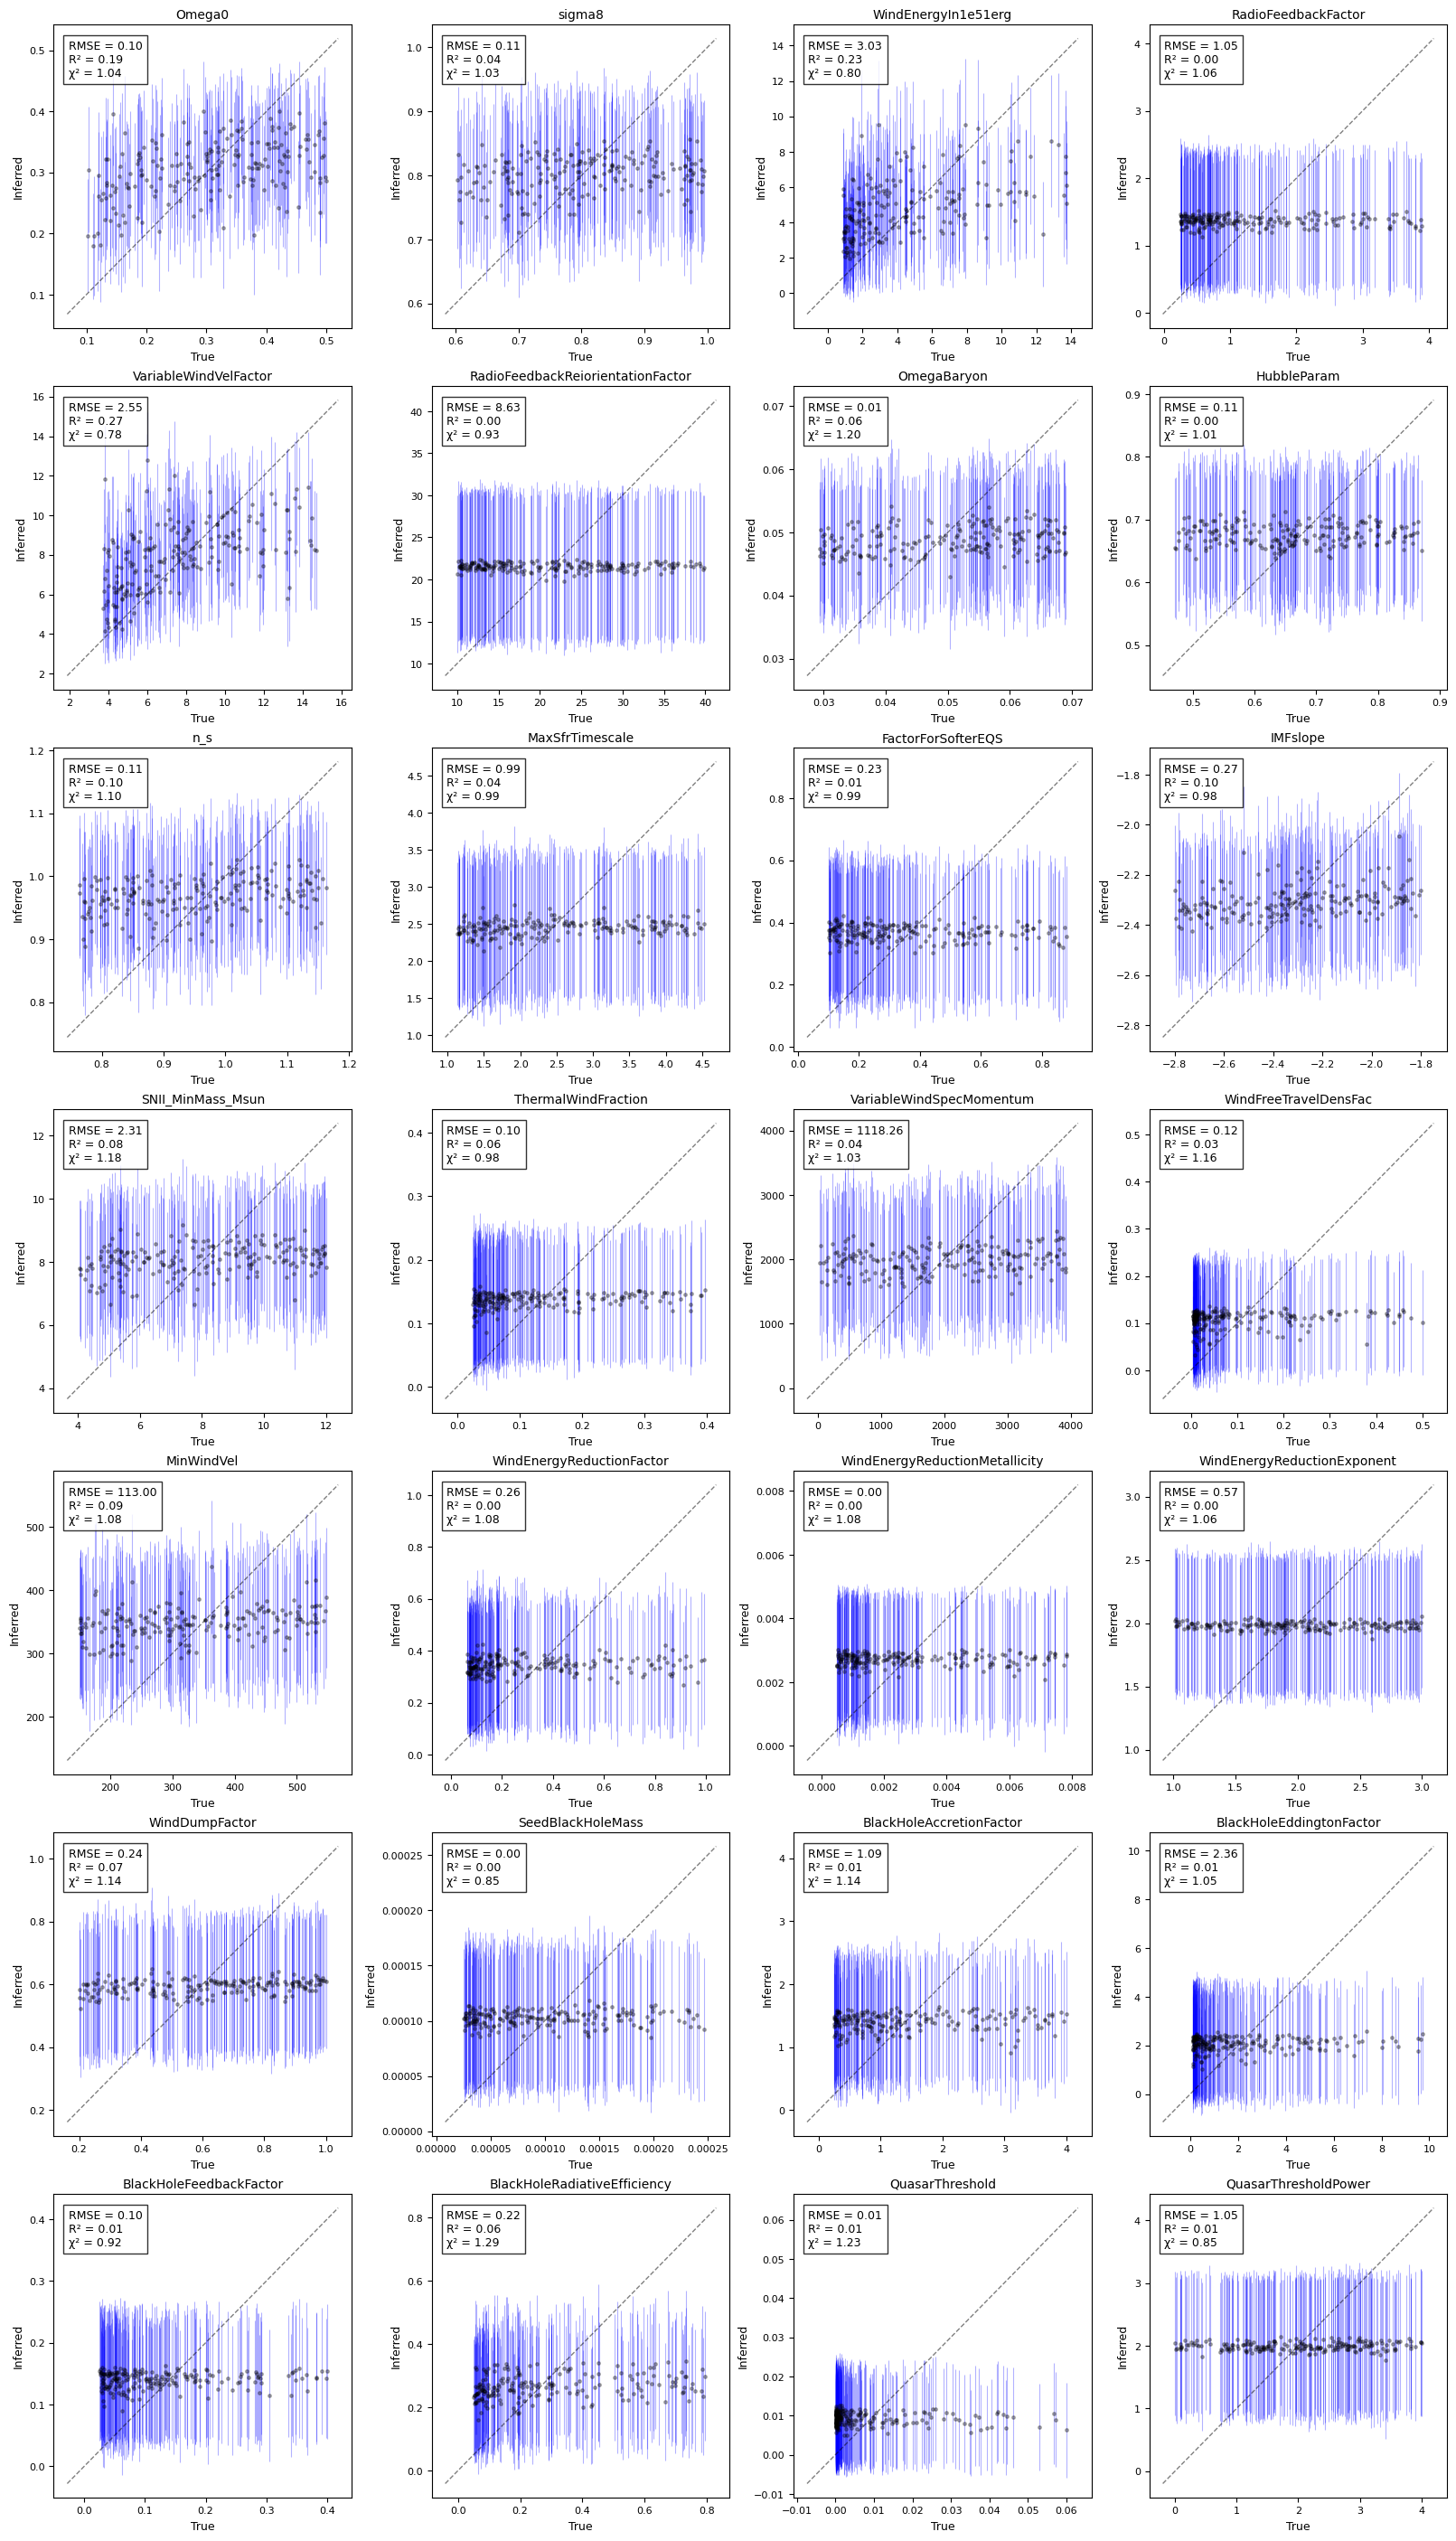

In [24]:

fig, axes = plt.subplots(7, 4, figsize=(16, 28)) 
axes = axes.flatten()

fontsize = 10  

plt.rcParams['figure.constrained_layout.use'] = True  

# Plot each parameter
for i in range(28):
    ax = axes[i]
    
    # True vs predicted with error bars
    ax.errorbar(
        theta_test[:, i].cpu().numpy(),
        all_means[:, i],
        yerr=all_stds[:, i],
        fmt='.',
        color='k',
        ecolor='blue',
        capsize=0,
        elinewidth=0.8,  
        alpha=0.3,       
        markersize=5    
    )
    
    # Add true line
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, '--', color='black', alpha=0.5, linewidth=1)
    
    # get metrics
    rmse = np.sqrt(np.mean((theta_test[:, i].cpu().numpy() - all_means[:, i])**2))
    r2 = np.corrcoef(theta_test[:, i].cpu().numpy(), all_means[:, i])[0, 1]**2
    chi2 = np.mean(((theta_test[:, i].cpu().numpy() - all_means[:, i])**2) / (all_stds[:, i]**2))
    
    # add metrics box in top left corner
    stats_text = f'RMSE = {rmse:.2f}\n' + \
                 f'R² = {r2:.2f}\n' + \
                 f'χ² = {chi2:.2f}'
    ax.text(0.05, 0.95, stats_text,
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8),
            verticalalignment='top',
            fontsize=fontsize-1)  # Slightly smaller font for stats
    
    # title: parameter name
    ax.set_title(param_names[i], fontsize=fontsize, pad=5)  # Reduced padding
    
    # axis labels
    ax.set_xlabel('True', fontsize=fontsize-1)
    ax.set_ylabel('Inferred', fontsize=fontsize-1)
    
    # tick labels
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
    
    # internal padding
    ax.margins(x=0.05, y=0.05)

# subplot spacing
plt.subplots_adjust(
    left=0.01,    # Less space on left
    right=0.7,   # Less space on right
    bottom=0.05,  # Less space at bottom
    top=0.7,     # Less space at top
    wspace=0.2,   # Less space between plots horizontally
    hspace=0.2    # Less space between plots vertically
)


# Save figure with detailed filename
save_path = f'{plots_out_dir}/posterior_predictions_{model_params}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
print(save_path)
plt.show()

### Looking at a specific case (one observation randomly set with seed)

['']


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_1700251/3809499650.py:101: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


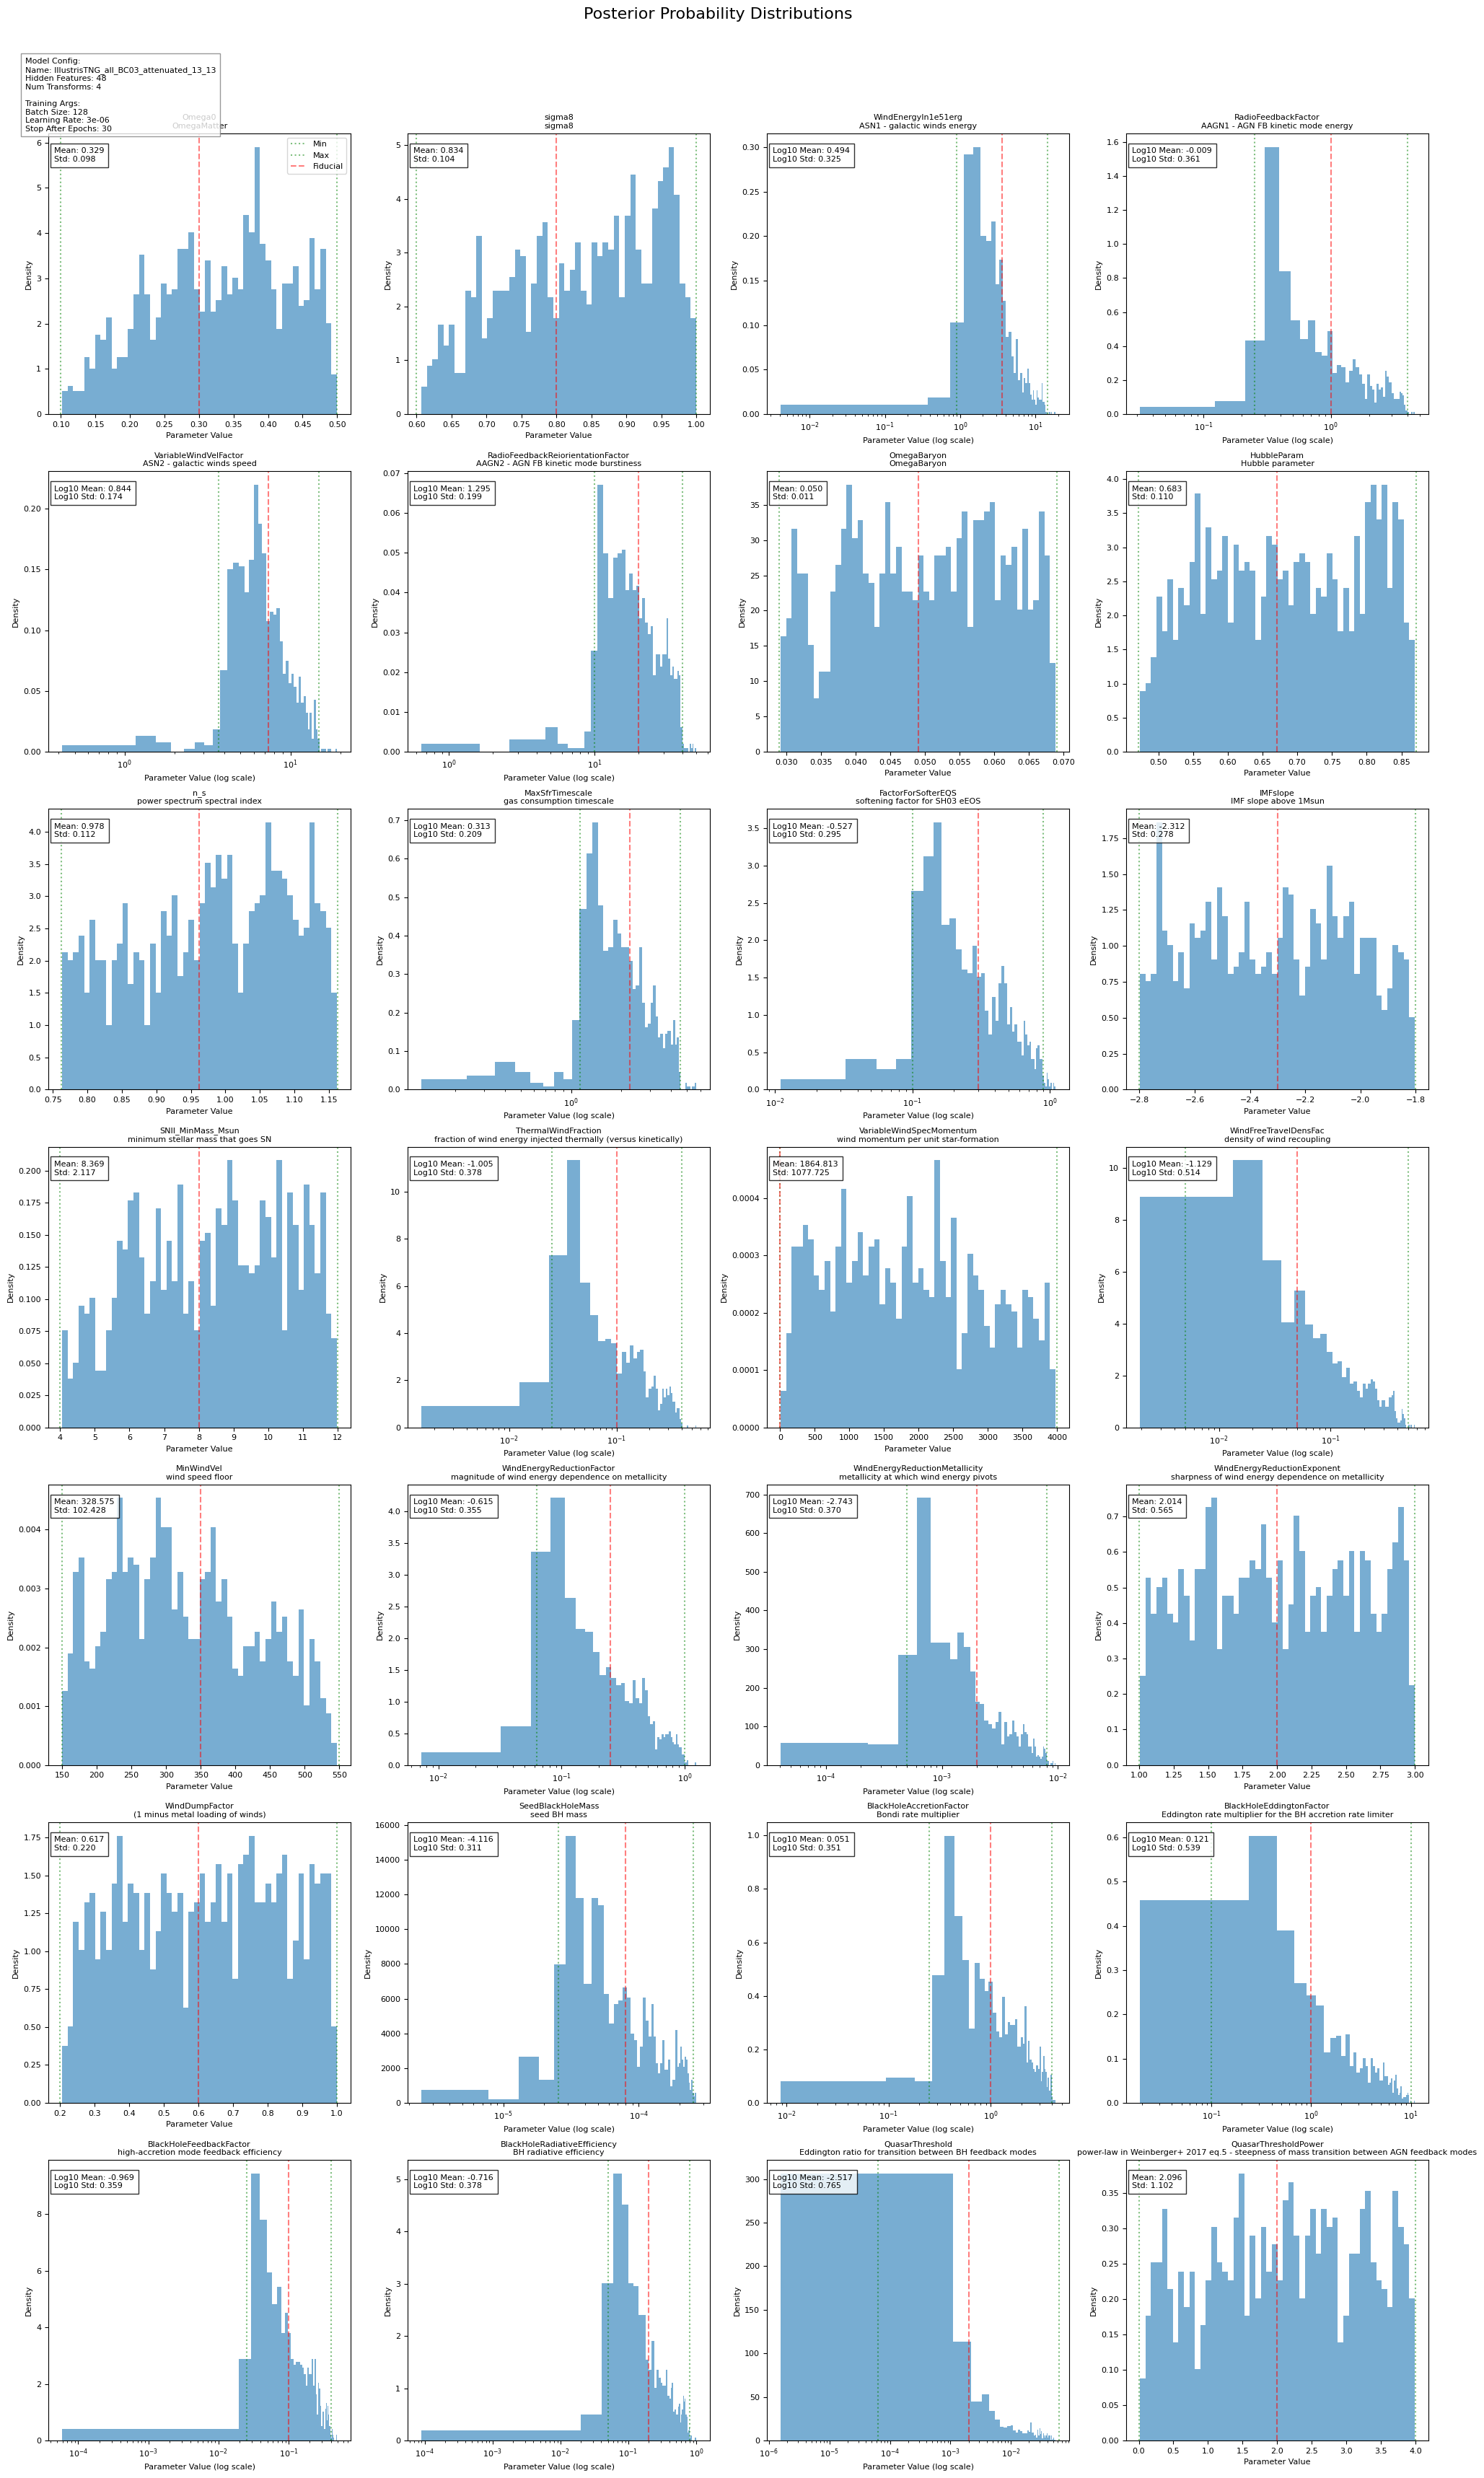

In [16]:
# Now, SBIRunner returns a custom class instance to be able to pass signature strings
# 1. prints our info on model configuration and architecture
print(posterior_ensemble.signatures)


# 2. choose a random input for training
seed_in = 49
np.random.seed(seed_in) # set seed for reproducability
ind = np.random.randint(len(x_train[0])) # choose observation (random index from training data)

# 3. generate posterior samples
seed_samp = 32
torch.manual_seed(seed_samp)# set seed for reproducability
# then, for the chosen training sample (as chosen above in 2.)
# generate 1000 samples from the posterior distribution using accept/reject sampling
samples = posterior_ensemble.sample(
    (1000,), 
    torch.Tensor(x_train[0][ind]).to(device))

# 4. calculate the probability densities for each sample
# i.e for each generated sample, calculate how likely it is using learned posterior distribution
log_prob = posterior_ensemble.log_prob(
    samples, # the generated samples from 3.
    torch.Tensor(x_train[0][ind]).to(device) # the chosen observation from 2.
    )

# convert to numpy so can read easier.
samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

from matplotlib.gridspec import GridSpec
def plot_posterior_samples_grid(samples, log_prob, param_names, df_info, model_name, train_args):
   n_params = len(param_names)
   n_cols = 4
   n_rows = (n_params + n_cols - 1) // n_cols
   
   fig = plt.figure(figsize=(20, 5*n_rows))
   
   # Add main title
   fig.suptitle('Posterior Probability Distributions', fontsize=16, y=0.98)
   
   gs = GridSpec(n_rows, n_cols, figure=fig)
   
   # Model info text
   model_info = (
       f"Model Config:\n"
       f"Name: {model_name}\n"
       f"Hidden Features: {hidden_features}\n"
       f"Num Transforms: {num_transforms}\n"
       f"\nTraining Args:\n"
       f"Batch Size: {train_args['training_batch_size']}\n"
       f"Learning Rate: {train_args['learning_rate']}\n"
       f"Stop After Epochs: {train_args['stop_after_epochs']}"
   )
   
   fig.text(0.02, 0.96, model_info, 
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
            verticalalignment='top')
   
   for i, name in enumerate(param_names):
       row = i // n_cols
       col = i % n_cols
       
       ax = fig.add_subplot(gs[row, col])
       data = samples[:, i]
       param_info = df_info[df_info['ParamName'] == name].iloc[0]
       is_log = param_info['LogFlag'] == 1
       
       if is_log:
           ax.hist(data, bins=50, density=True, alpha=0.6)
           ax.set_xscale('log')
           log_data = np.log10(data)
           mean = np.mean(log_data)
           std = np.std(log_data)
           stats_text = f'Log10 Mean: {mean:.3f}\nLog10 Std: {std:.3f}'
           ax.set_xlabel('Parameter Value (log scale)', fontsize=8)
       else:
           ax.hist(data, bins=50, density=True, alpha=0.6)
           mean = np.mean(data)
           std = np.std(data)
           stats_text = f'Mean: {mean:.3f}\nStd: {std:.3f}'
           ax.set_xlabel('Parameter Value', fontsize=8)
       
       ax.set_ylabel('Density', fontsize=8)
       
       ax.axvline(param_info['MinVal'], color='g', linestyle=':', alpha=0.5, label='Min')
       ax.axvline(param_info['MaxVal'], color='g', linestyle=':', alpha=0.5, label='Max')
       ax.axvline(param_info['FiducialVal'], color='r', linestyle='--', alpha=0.5, label='Fiducial')
       
       ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, 
               verticalalignment='top', fontsize=8, 
               bbox=dict(facecolor='white', alpha=0.8))
       
       ax.set_title(f"{name}\n{param_info['Description']}", fontsize=8, pad=5)
       ax.tick_params(labelsize=8)
       
       if i == 0:
           ax.legend(loc='upper right', fontsize=8)
   
   plt.tight_layout()
   plt.subplots_adjust(top=0.93)  # Adjusted to make room for main title
   return fig

# Get all parameter names from df_info
param_names = df_info['ParamName'].tolist()

# Now try plotting again with the correct parameter names
fig = plot_posterior_samples_grid(
    samples, 
    log_prob, 
    param_names,  # Now contains all 28 parameter names correctly
    df_info,
    model_name=name,
    train_args=train_args
)

# Save with model config in filename
save_name = (f'parameter_posteriors_grid_{name}_'
            f'h{hidden_features}_t{num_transforms}_'
            f'b{train_args["training_batch_size"]}_'
            f'e{train_args["stop_after_epochs"]}.png')

os.makedirs(plots_out_dir, exist_ok=True)
plt.savefig(os.path.join(plots_out_dir, save_name), 
            dpi=300, 
            bbox_inches='tight')